In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import scipy

import warnings
warnings.filterwarnings('ignore')

def export_legend(legend, filename="test.pdf", expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

Plotting for Block religion
Plotting for Block politics
Plotting for Block age
Plotting for Block gender
Plotting for Block sexuality


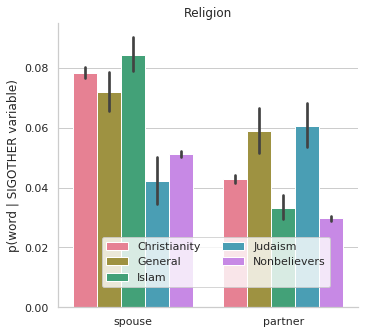

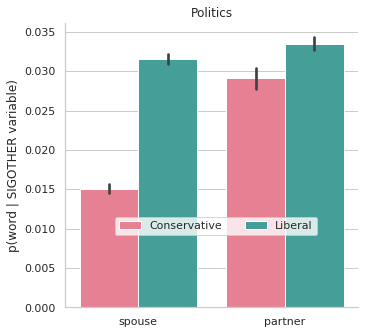

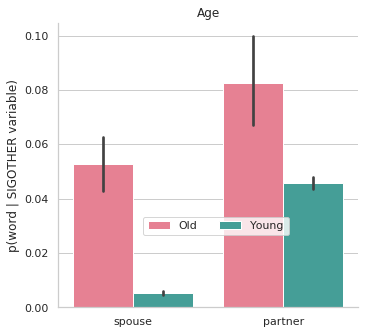

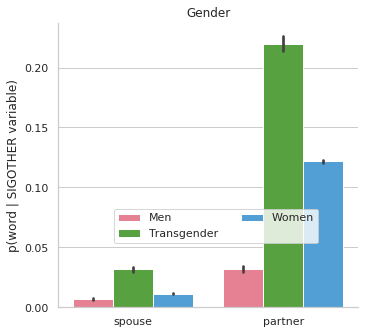

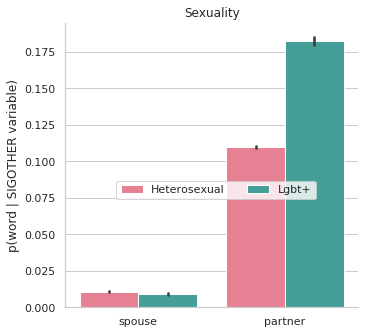

In [90]:
# FINAL PLOT FOR PARTNER, PRP USAGES ONLY, ALL
# REDDIT CATEGORIES
sns.set(style="whitegrid")

df = pd.read_csv("partner-possessive-categories-withgeo-2.txt", sep='\t',
                names=['percentage', 'word', 'trial', 'year', 'month', 'subreddit', 'category'])
df = pd.concat([df[~df['category'].str.contains("sexuality")], df.loc[df['category'] == 'sexuality_asexual']])
df2 = pd.read_csv("partner-possessive-categories-heterovslgbt-2.txt", sep='\t',
                  names=['percentage', 'word', 'trial', 'year', 'month', 'subreddit', 'category'])
df = pd.concat([df, df2])
df = df[df['word'].isin(['partner', 'spouse'])]

###
df.loc[df['category'] == 'gender_other', 'category'] = 'gender_Gender Critical'
df = df[df['category'] != 'religion_eastern']
df = df[df['category'] != 'politics_general']
###

### SUNDAY CHANGES ###
df.loc[df['category'] == 'politics_left', 'category'] = 'politics_liberal' 
df.loc[df['category'] == 'politics_right', 'category'] = 'politics_conservative' 
df.loc[df['category'] == 'sexuality_heteronormative', 'category'] = 'sexuality_heterosexual' 
######################

### Inclusivity Changes ###
df = df[df['category'] != 'politics_libertarian']
df = df[df['category'] != 'gender_Gender Critical']
df = df[df['category'] != 'sexuality_asexual']
df.loc[df['category'] == 'sexuality_lgbtq', 'category'] = 'sexuality_LGBT+' 
##########################

for block in ['religion', 'politics', 'age', 'gender', 'sexuality']:
    print("Plotting for Block", block)
    block_df = df[df['category'].str.contains(block)]
    
    for cat in block_df['category'].unique():
        block_df.loc[block_df['category'] == cat, 'category'] = (cat[len(block)+1:]).capitalize()
    block_df.rename(columns = {'category':'Community Group'}, inplace = True)
    
    ###
    block_df = block_df.sort_values(['word', 'Community Group'], ascending=[False, True]).reset_index(drop=True)
    ###
    
    fig = sns.catplot(x='word', y='percentage', hue='Community Group', data=block_df,
        kind='bar', dodge=True, ci=95, palette="husl", legend = False, legend_out = False)  
    fig.set(xlabel='', ylabel='p(word | SIGOTHER variable)', title=block.capitalize())
    fig.fig.subplots_adjust(top=.88)
    if block == 'sexuality':
        fig.fig.legend(ncol = 2, bbox_to_anchor = (0.6,0.4), loc='center')
    elif block == 'religion':
        fig.fig.legend(ncol = 2, bbox_to_anchor = (0.6,0.2), loc='center')
    else:
        fig.fig.legend(ncol = 2, bbox_to_anchor = (0.6,0.3), loc='center')
    plt.savefig('plots-final/partner-prp-all/' + block + '.pdf', bbox_inches='tight')

Plotting Age Dependency Index (By Quartile)
Plotting Median Household Income (By Quartile)
Plotting Per Capita Income (By Quartile)
Plotting %Population With Public Assistance (By Quartile)
Plotting %Population With Bachelor&+ Degree (By Quartile)
Plotting %Population With Graduate&+ Degree (By Quartile)
Plotting Population Density (By Quartile)
Plotting Percent Unemployed (By Quartile)
Plotting Gini Coefficient (By Quartile)
Plotting Percent Black (By Quartile)
Plotting Average Household Size (By Quartile)
Plotting %Population Below Poverty (By Quartile)


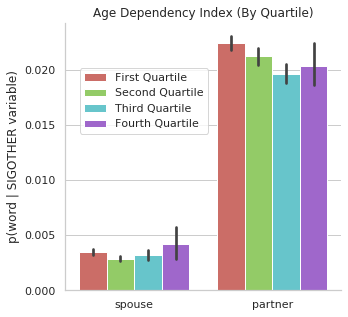

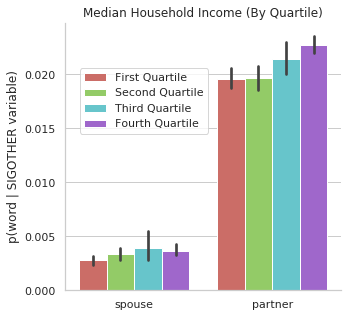

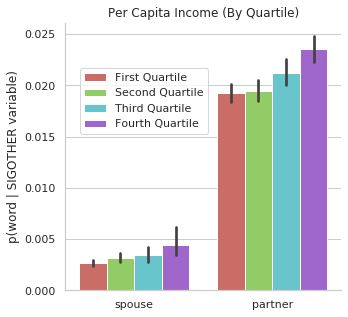

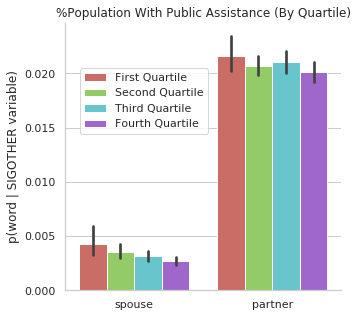

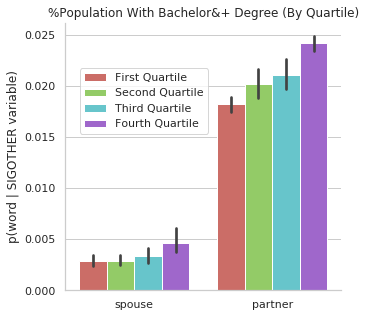

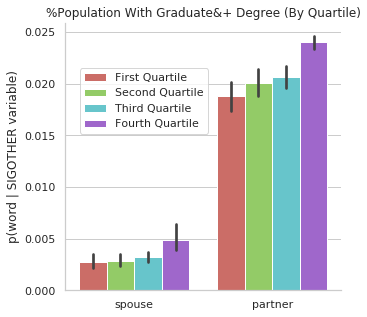

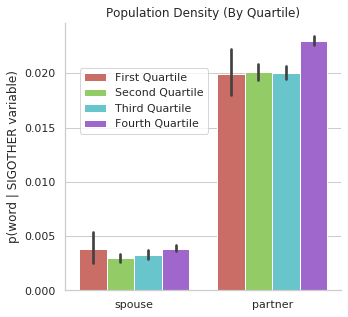

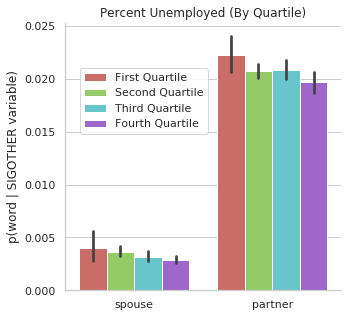

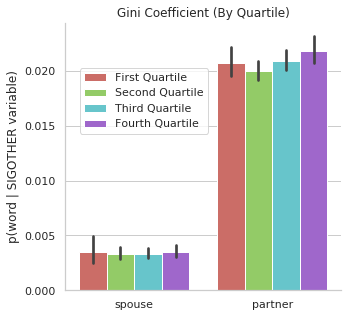

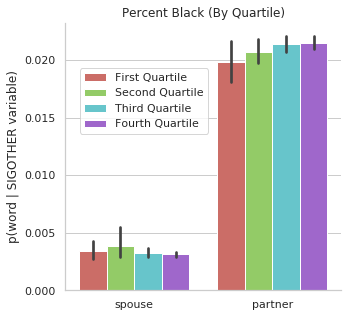

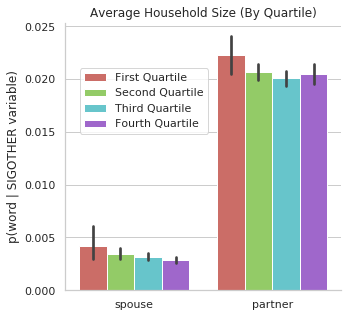

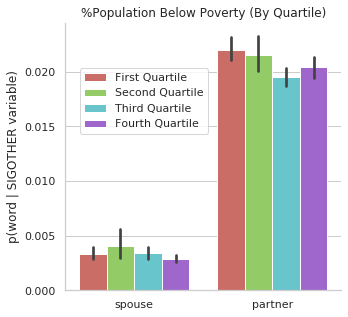

In [169]:
# FINAL PLOT FOR PARTNER, PRP USAGES ONLY, ALL
# TWITTER SES
sns.set(style="whitegrid")

df = pd.read_csv("acsdata-allyears-partner-prp.csv")
ses_cols = {"var_age_dependency_index": "Age Dependency Index (By Quartile)",
           "var_median_household_income": "Median Household Income (By Quartile)",
           "var_per_capita_income": "Per Capita Income (By Quartile)",
           "var_percent_households_with_public_assistance": "%Population With Public Assistance (By Quartile)",
           "var_percent_with_bachelorandhigher_25andolder": "%Population With Bachelor&+ Degree (By Quartile)",
           "var_percent_with_graduateandhigher_25andolder": "%Population With Graduate&+ Degree (By Quartile)",
           "POPDENSITY": "Population Density (By Quartile)",
           "var_percent_unemployed": "Percent Unemployed (By Quartile)",
           "var_gini": "Gini Coefficient (By Quartile)",
           "var_percent_black": "Percent Black (By Quartile)",
           "var_average_household_size": "Average Household Size (By Quartile)",
           "var_percent_below_poverty": "%Population Below Poverty (By Quartile)"}
words_to_keep = ["spouse", "partner"]

### Population Density ###
usapd_df = pd.read_csv("USA_Population_Density.csv")
usapd_df = usapd_df[["ID", "LANDAREA", "TOTPOP_CY"]]
usapd_df['ID'] = usapd_df['ID'].astype(str)
usapd_df['ID'] = usapd_df['ID'].str[:-6]
usapd_df = usapd_df.groupby(["ID"],as_index=False).agg({'LANDAREA': 'sum', 'TOTPOP_CY': 'sum'})
usapd_df['POPDENSITY'] = usapd_df['TOTPOP_CY'] / usapd_df['LANDAREA']
usapd_df.rename(columns = {'ID':'FIPS'}, inplace = True)
usapd_df['FIPS'] = usapd_df['FIPS'].astype(int)
##########################

df = df.merge(usapd_df, on="FIPS", how="left")
df = df[words_to_keep + list(ses_cols.keys())]

# Quartile Separation and LFDF construction
quartile_names = ["First Quartile", "Second Quartile", "Third Quartile", "Fourth Quartile"]
lfdf_data = []
for col in ses_cols:
    quartiles = df[col].quantile([0.25,0.5,0.75]).tolist()
    df[col + "_quartiles"] = ""
    df.loc[(df[col] <= quartiles[0]), col + "_quartiles"] = quartile_names[0]
    df.loc[(df[col] > quartiles[0]) & (df[col] <= quartiles[1]), col + "_quartiles"] = quartile_names[1]
    df.loc[(df[col] > quartiles[1]) & (df[col] <= quartiles[2]), col + "_quartiles"] = quartile_names[2]
    df.loc[(df[col] > quartiles[2]), col + "_quartiles"] = quartile_names[3]
    
    for idx, row in df.iterrows():
        # word, percentage, quartile, category
        if row[col + "_quartiles"] in quartile_names:
            lfdf_data.append({'word': 'partner', 'percentage': row['partner'], 'quartile':row[col + "_quartiles"], 'ses':col})
            lfdf_data.append({'word': 'spouse', 'percentage': row['spouse'], 'quartile':row[col + "_quartiles"], 'ses':col})
df = pd.DataFrame.from_dict(lfdf_data, orient='columns')
df['quartile'] = pd.Categorical(df['quartile'], quartile_names)
df['word'] = pd.Categorical(df['word'], words_to_keep)

# Plotting
for col in ses_cols:
    print("Plotting", ses_cols[col])
    block_df = df[df['ses'] == col]
    block_df.sort_values(['word', 'quartile'])
    
    fig = sns.catplot(x='word', y='percentage', hue='quartile', data=block_df,
                     kind='bar', dodge=True, ci=95, palette="hls", legend = False, legend_out = False)
    fig.set(xlabel='', ylabel='p(word | SIGOTHER variable)', title=ses_cols[col])
    fig.fig.subplots_adjust(top=.88)
    fig.fig.legend(bbox_to_anchor = (0.4,0.6), loc='center')
    plt.savefig('plots-final/partner-prp-all-ses/' + col + '.pdf', bbox_inches='tight')

In [342]:
# FINAL PLOT FOR PARTNER, PRP USAGES ONLY, OVER TIME
# REDDIT CATEGORIES
# PART ONE

timeaxisname = 'time'

# Messy Read-ins
df = pd.read_csv("partner-possessive-categories-withgeo-2.txt", sep='\t',
                names=['percentage', 'word', 'trial', 'year', 'month', 'subreddit', 'category'])
df = pd.concat([df[~df['category'].str.contains("sexuality")], df.loc[df['category'] == 'sexuality_asexual']])
df2 = pd.read_csv("partner-possessive-categories-heterovslgbt-2.txt", sep='\t',
                  names=['percentage', 'word', 'trial', 'year', 'month', 'subreddit', 'category'])
df = pd.concat([df, df2])

# Filter for SIGOTHER terms
df = df[df['word'].isin(['partner', 'spouse', 'girlfriend', 'boyfriend', 'husband', 'wife'])]

# # Formatting
df[timeaxisname] = ''
for index, row in tqdm(df.iterrows(), total=len(df)):
    if int(row['month']) in range(1,7):
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '1-6 Mo'
    else:
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '7-12 Mo'
timeaxis_sorted = df[timeaxisname].sort_values().unique()
# df['month'] = df.month.map("{:02}".format)
# df[timeaxisname] = df.year.map(str) + "-" + df.month
# df[timeaxisname] = pd.to_datetime(df[timeaxisname])
# timeaxis_sorted = df[timeaxisname].dt.strftime('%Y-%m').sort_values().unique()

temp = []
for idx, x in enumerate(timeaxis_sorted):
    if '1-' in x: temp.append(x[0:4])
    else: temp.append('')
timeaxis_sorted = temp

# Cleanup Filtering
#df = df[['percentage', 'word', 'subreddit', 'category', 'trial', 'time']]

Plotting for Block sexuality
Heterosexual (0.954707879809719, 1.1300529014338812e-07)
Lgbtq (0.8477754762108868, 0.00012833607719444005)
Plotting for Block gender
Men (0.7314917493724946, 0.0029466971177485573)
Transgender (0.44408326594508796, 0.11166538005852183)
Women (0.8842805617756414, 2.689827014509087e-05)
Plotting for Block religion
Christianity (0.6509083981906023, 0.011697787201353248)
General (0.02629026049342148, 0.9289133588527166)
Islam (0.3890461368815415, 0.16917550535834247)
Judaism (0.09914321049861184, 0.7359614747187514)
Nonbelievers (0.6819303496150261, 0.0072229918092742195)
Plotting for Block politics
Conservative (0.8547401428891821, 0.0033270931758955192)
Liberal (-0.49030388185981943, 0.07508718073634886)
Libertarian (0.22095704539265476, 0.4681815101566177)
Plotting for Block age
Old (0.461772705830263, 0.21082101373796172)
Young (0.6804953136836943, 0.007394773869173309)


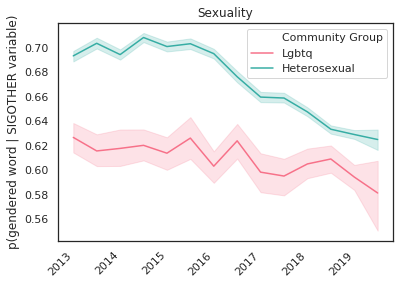

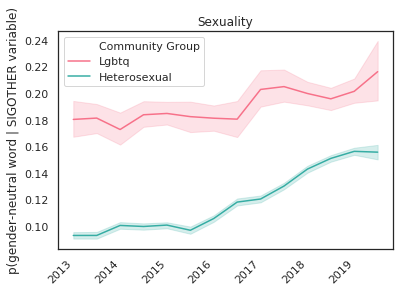

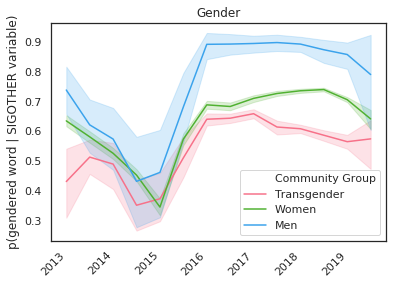

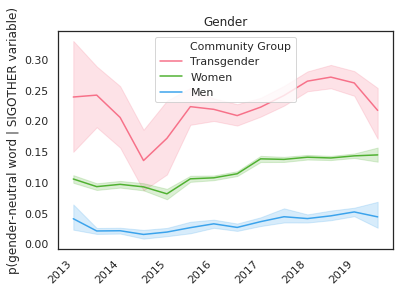

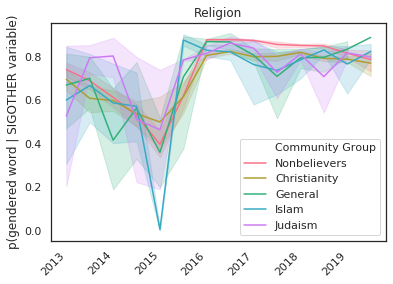

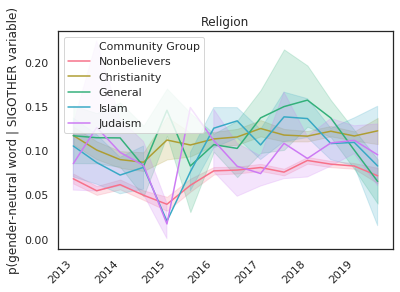

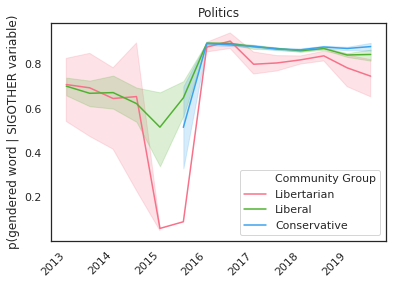

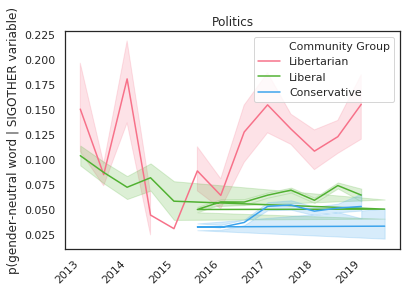

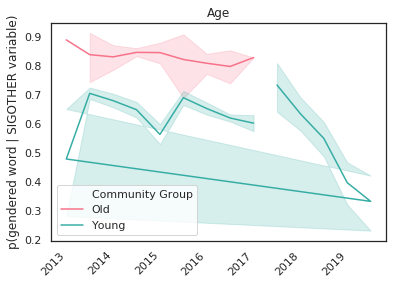

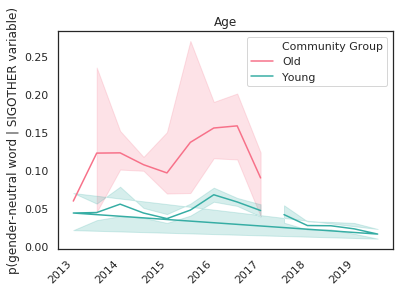

In [351]:
# FINAL PLOT FOR PARTNER, PRP USAGES ONLY, OVER TIME
# REDDIT CATEGORIES
# PART TWO
sns.set_style("white")

### SUNDAY CHANGES ###
df.loc[df['category'] == 'politics_left', 'category'] = 'politics_liberal' 
df.loc[df['category'] == 'politics_right', 'category'] = 'politics_conservative' 
df.loc[df['category'] == 'sexuality_heteronormative', 'category'] = 'sexuality_heterosexual' 
######################

# Plotting Goodness
for block in ['sexuality', 'gender', 'religion', 'politics', 'age']:
    print("Plotting for Block", block)
    block_df = df[df['category'].str.contains(block)]
    
    # Sexuality
    block_df = block_df[block_df['category'] != 'sexuality_asexual']
    # Gender
    block_df.loc[block_df['category'] == 'gender_other', 'category'] = 'gender_Gender Critical'
    block_df = block_df[block_df['category'] != 'gender_Gender Critical']
    # Politics
    block_df = block_df[block_df['category'] != 'politics_general']
    # Religion
    block_df = block_df[block_df['category'] != 'religion_eastern']
    # block_df = block_df[block_df['word'] != 'spouse']
    
    for cat in block_df['category'].unique():
        block_df.loc[block_df['category'] == cat, 'category'] = (cat[len(block)+1:]).capitalize()
    block_df.rename(columns = {'category':'Community Group'}, inplace = True)
    
    ### Heteronormative Terms VS Gender-Neutral ###
    
    plt.figure()
    block_df_1 = block_df[block_df['word'].isin(['girlfriend', 'boyfriend', 'husband', 'wife'])]
    block_df_1 = block_df_1.groupby(['subreddit', 'Community Group', 'trial', 'time', 'month', 'year'], as_index=False).agg({'percentage': 'sum'})
    fig = sns.lineplot(x=timeaxisname, y="percentage", hue="Community Group", data=block_df_1,
                       palette="husl")
    fig.set(xlabel='', ylabel='p(gendered word | SIGOTHER variable)', title=block.capitalize())
    ax = plt.gca()
    ax.set_xticklabels(labels=timeaxis_sorted, rotation=45, ha='right')
    plt.savefig('plots-final/partner-prp-time/' + block + '-gendered.pdf', bbox_inches='tight')
    
    plt.figure()
    block_df_2 = block_df[block_df['word'].isin(['partner', 'spouse'])]
    block_df_2 = block_df_2.groupby(['subreddit', 'Community Group', 'trial', 'time', 'month', 'year'], as_index=False).agg({'percentage': 'sum'})
    fig = sns.lineplot(x=timeaxisname, y="percentage", hue="Community Group", data=block_df_2,
                       palette="husl")
    fig.set(xlabel='', ylabel='p(gender-neutral word | SIGOTHER variable)', title=block.capitalize())
    ax = plt.gca()
    ax.set_xticklabels(labels=timeaxis_sorted, rotation=45, ha='right')
    plt.savefig('plots-final/partner-prp-time/' + block + '-genderneutral.pdf', bbox_inches='tight')
    
    ### Correlations for Gender-Neutral ###
    
    block_df_2 = block_df_2.groupby(['Community Group', 'time'], as_index=False).agg({'percentage': 'mean'})
    for c_g in block_df_2['Community Group'].unique():
        values = block_df_2[block_df_2['Community Group'] == c_g].sort_values(by=['time'], ascending=True)['percentage'].tolist()
        pr = pearsonr(range(len(values)), values)
        print(c_g, pr)
        
    
#     # Plotting for specific words:
#     for word in block_df['word'].unique():
#         plt.figure()
#         block_df_word = block_df[block_df['word'] == word]
#         fig = sns.lineplot(x=timeaxisname, y="percentage", hue="Community Group", data=block_df_word,
#                       palette="husl")
#         fig.set(ylabel='p(' + word + ' | SIGOTHER variable)', title=block.capitalize())

#         ax = plt.gca()
#         ax.set_xticklabels(labels=timeaxis_sorted, rotation=45, ha='right')
#         plt.savefig('plots-final/partner-prp-time/' + block + '-' + word + '.pdf', bbox_inches='tight')

['guy', 'man', 'bro', 'dude', 'mate', 'fam', 'buddy', 'dawg', 'pal', 'homie', 'comrade', 'fella', 'girl', 'person', 'individual', 'dawgs', 'dudes', 'peeps', 'folks', 'dudettes', 'persons', 'bros', 'guys', 'girls', 'comrades', 'buddies', 'pals', 'mates', 'homies', 'people']
Plotting for Block religion
Plotting for Block politics
Plotting for Block age
Plotting for Block gender
Plotting for Block sexuality


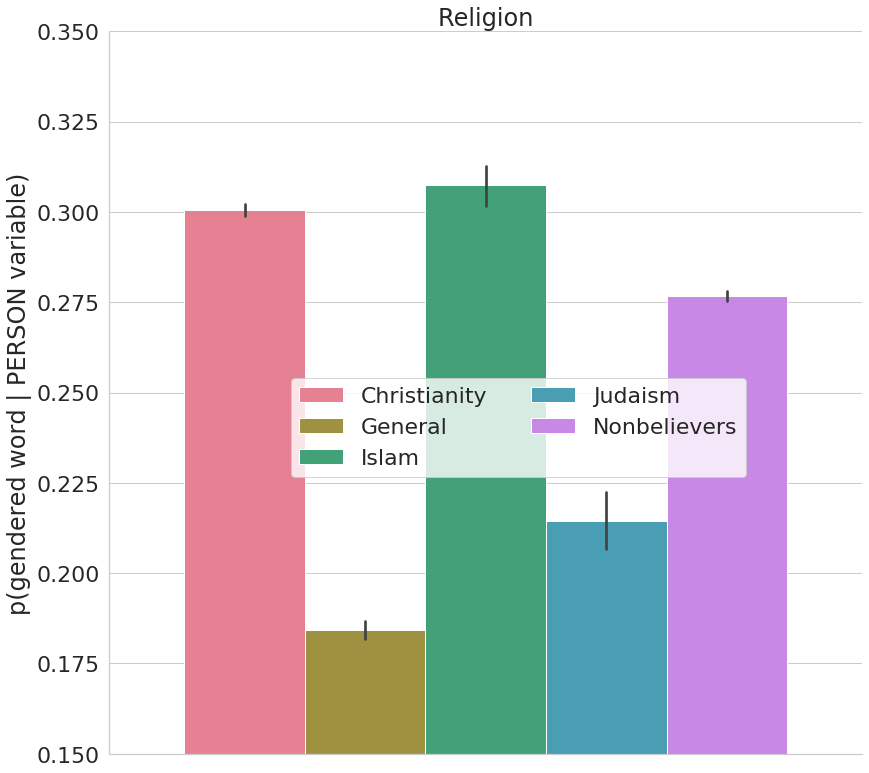

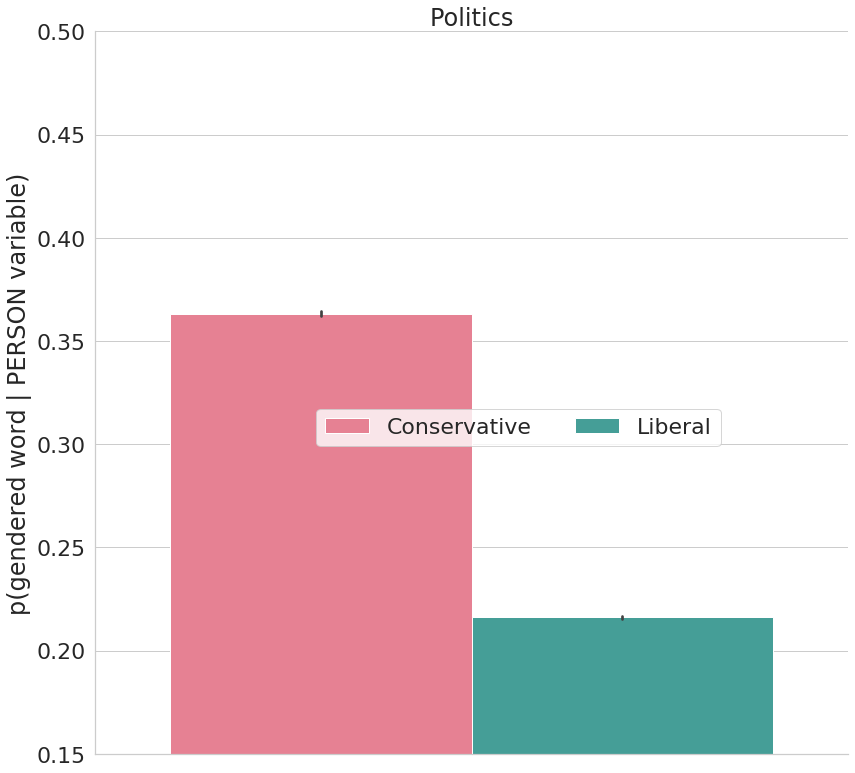

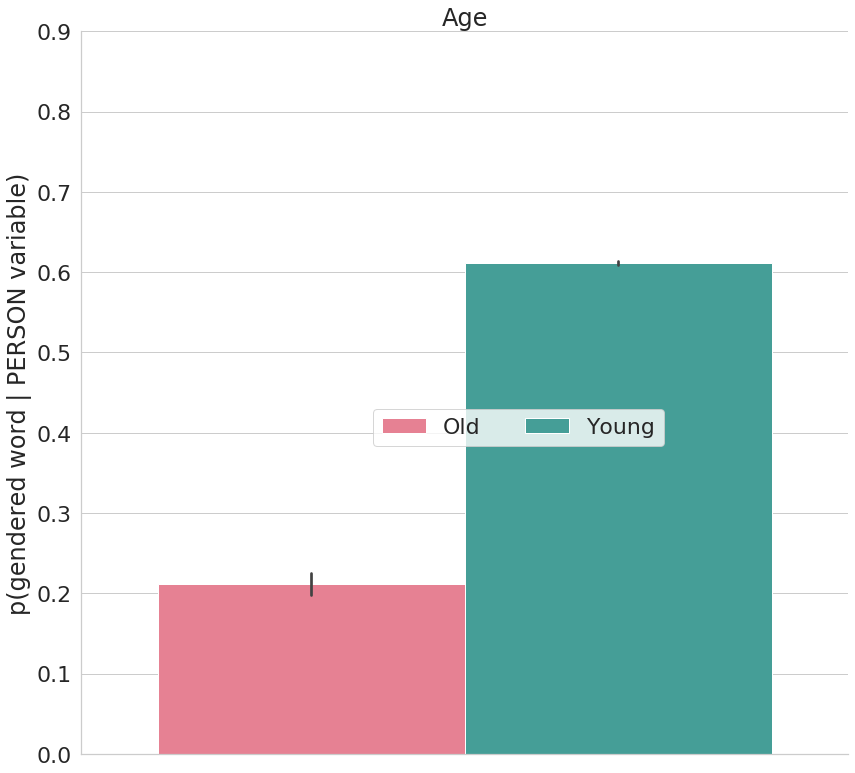

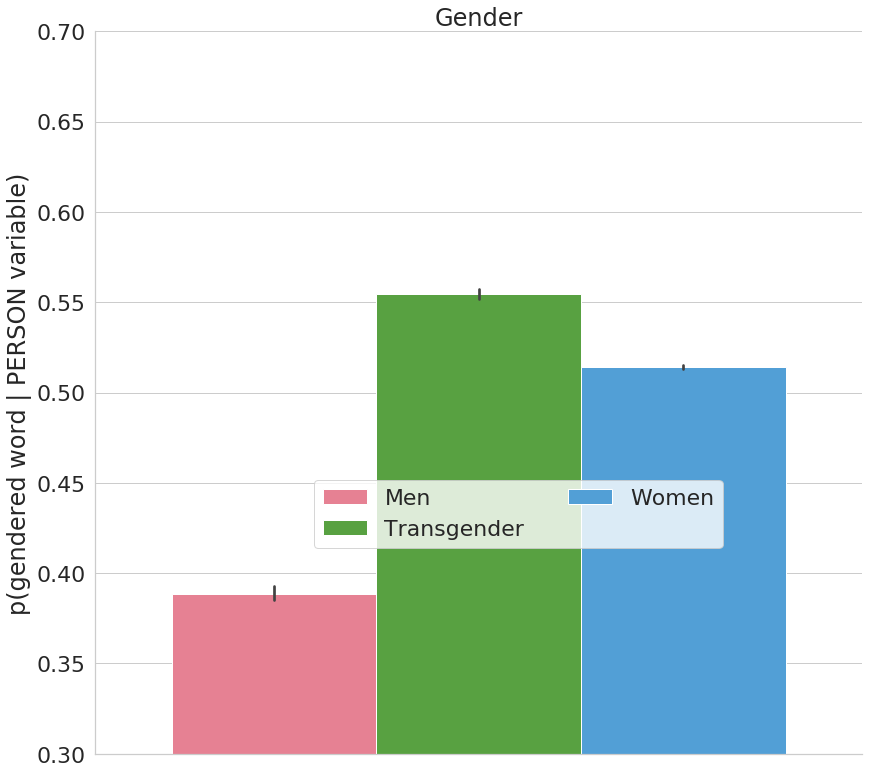

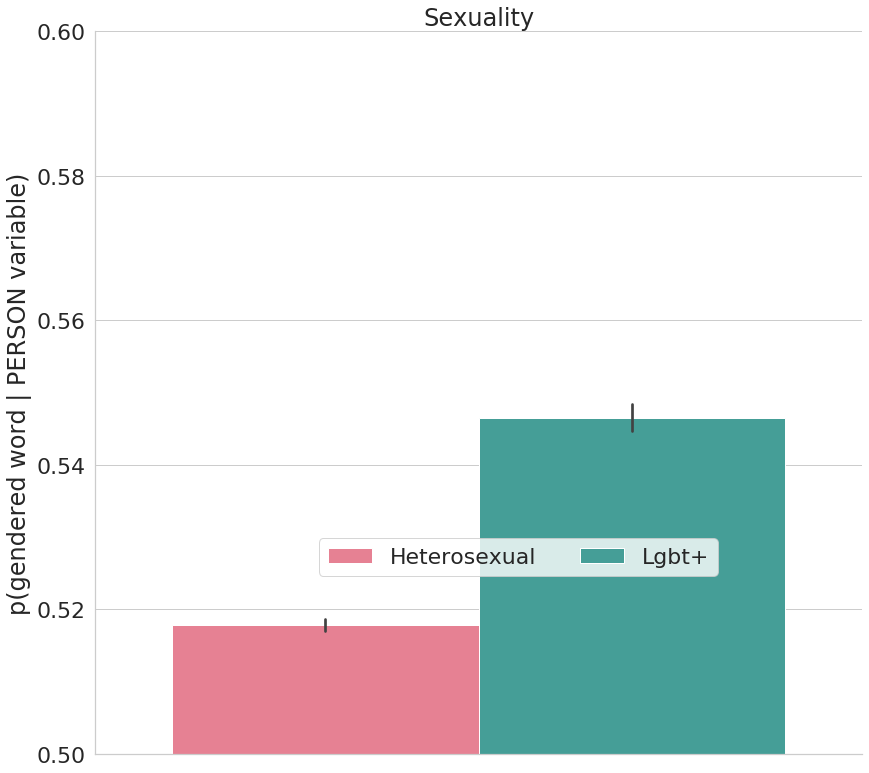

In [100]:
# FINAL PLOT FOR DUDE, CONTROLLED DT ONLY, ALL
# REDDIT CATEGORIES
sns.set(font_scale=2, style="whitegrid")

df = pd.read_csv("repercent3.txt",
                sep='\t', names=['percentage', 'word', 'trial', 'year', 'month', 'category', 'num_valid'])
df = df[df['category']!='geo']
df = df[df['category']!='politics_general']
df = df[df['category']!='religion_other']
df = df[df['category']!='religion_eastern']
df.loc[df['category'] == 'gender_other', 'category'] = 'gender_Gender Critical'

### SUNDAY CHANGES ###
df.loc[df['category'] == 'politics_left', 'category'] = 'politics_liberal' 
df.loc[df['category'] == 'politics_right', 'category'] = 'politics_conservative' 
df.loc[df['category'] == 'sexuality_heteronormative', 'category'] = 'sexuality_heterosexual' 
######################

### Inclusivity Changes ###
df = df[df['category'] != 'politics_libertarian']
df = df[df['category'] != 'gender_Gender Critical']
df = df[df['category'] != 'sexuality_asexual']
df.loc[df['category'] == 'sexuality_lgbtq', 'category'] = 'sexuality_LGBT+' 
##########################

print(df['word'].unique().tolist())
# Gendered v. Non-Gendered
gendered = ['guy', 'man', 'bro', 'dude', 'girl', 'fella', 
           'dudettes', 'bros', 'guys', 'girls', 'dudes']
non_gendered = ['fam', 'buddy', 'dawg', 'pal', 'homie', 'comrade', 'person', 'individual', 'mate',
               'dawgs', 'peeps', 'folks', 'persons', 'comrades', 'buddies', 'pals', 'mates', 'homies', 'people']

# GENDERED VS NONGENDERED
df['gendered'] = 'gendered'
df.loc[df['word'].isin(non_gendered), 'gendered'] = 'non-gendered'
df = df.groupby(['trial', 'year', 'month', 'category', 'gendered'],as_index=False).agg({'percentage': 'sum'})

df = pd.pivot_table(df, values = 'percentage', index=['trial', 'year', 'month', 'category'], columns = 'gendered').reset_index()
df['gendered-non-gendered'] = df['gendered'] - df['non-gendered']

df['emptylabel'] = ''

for block in ['religion', 'politics', 'age', 'gender', 'sexuality']:
    print("Plotting for Block", block)
    block_df = df[df['category'].str.contains(block)]
    
    for cat in block_df['category'].unique():
        block_df.loc[block_df['category'] == cat, 'category'] = (cat[len(block)+1:]).capitalize()
    block_df.rename(columns = {'category':'Community Group'}, inplace = True)
    
    ###
    block_df = block_df.sort_values(['Community Group'], ascending=[True]).reset_index(drop=True)
    ###
    
    fig = sns.catplot(x='emptylabel', y='gendered', hue='Community Group', data=block_df,
                        kind='bar', dodge=True, ci=95, palette="husl", legend = False, legend_out = False,
                        height=12, aspect=1)
    fig.set(xlabel='', ylabel='p(gendered word | PERSON variable)', title=block.capitalize())
    fig.fig.subplots_adjust(top=.88)
    
    if block == 'religion':
        plt.ylim(0.15, 0.35)
        #plt.legend(loc="center right", bbox_to_anchor=(3.0,0.5), fontsize=30)
        fig.fig.legend(ncol = 2, bbox_to_anchor = (0.6,0.4), loc='center')
    if block == 'politics':
        plt.ylim(0.15, 0.5)
        #plt.legend(loc="center right", bbox_to_anchor=(3.0,0.5), fontsize=30)
        fig.fig.legend(ncol = 2, bbox_to_anchor = (0.6,0.4), loc='center')
    if block == 'age':
        plt.ylim(0.0, 0.9)
        #plt.legend(loc="center right", bbox_to_anchor=(2.4,0.5), fontsize=30)
        fig.fig.legend(ncol = 2, bbox_to_anchor = (0.6,0.4), loc='center')
    if block == 'gender':
        plt.ylim(0.3, 0.7)
        #plt.legend(loc="center right", bbox_to_anchor=(3.0,0.5), fontsize=30)
        fig.fig.legend(ncol = 2, bbox_to_anchor = (0.6,0.3), loc='center')
    if block == 'sexuality':
        plt.ylim(0.5, 0.6)
        #plt.legend(loc="center right", bbox_to_anchor=(3.0,0.5), fontsize=30)
        fig.fig.legend(ncol = 2, bbox_to_anchor = (0.6,0.25), loc='center')
    
    #fig.axes.flatten()[0].set_title("")
    
    plt.savefig('plots-final/dude-controlled/' + block + '.pdf', bbox_inches='tight')


Index(['Unnamed: 0', 'FIPS', 'bro', 'buddies', 'buddy', 'dawg', 'dawgs',
       'dude', 'dudes', 'fam', 'fella', 'folks', 'girl', 'girls', 'guy',
       'guys', 'homie', 'homies', 'individual', 'man', 'mate', 'pal', 'peeps',
       'people', 'person', 'persons', 'bros', 'comrade', 'pals', 'mates',
       'comrades', 'dudettes', 'var_percent_unemployed', 'var_gini',
       'var_median_gross_rent', 'var_median_household_income',
       'var_mean_household_income_lowest_quintile',
       'var_mean_household_income_second_quintile',
       'var_mean_household_income_third_quintile',
       'var_mean_household_income_fourth_quintile',
       'var_mean_household_income_fifth_quintile',
       'var_mean_household_income_top_five_percent', 'var_per_capita_income',
       'var_percent_owner_occupied_housing', 'var_percent_below_poverty',
       'var_percent_white', 'var_percent_black', 'var_percent_indian',
       'var_percent_asian', 'var_percent_not_hispanic_latino',
       'var_average_house

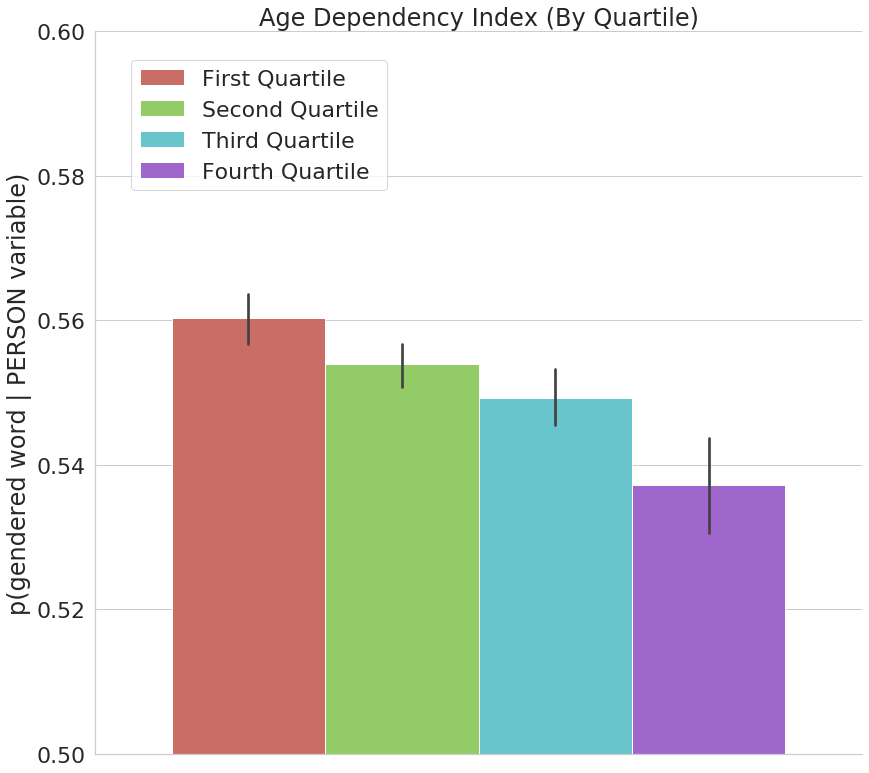

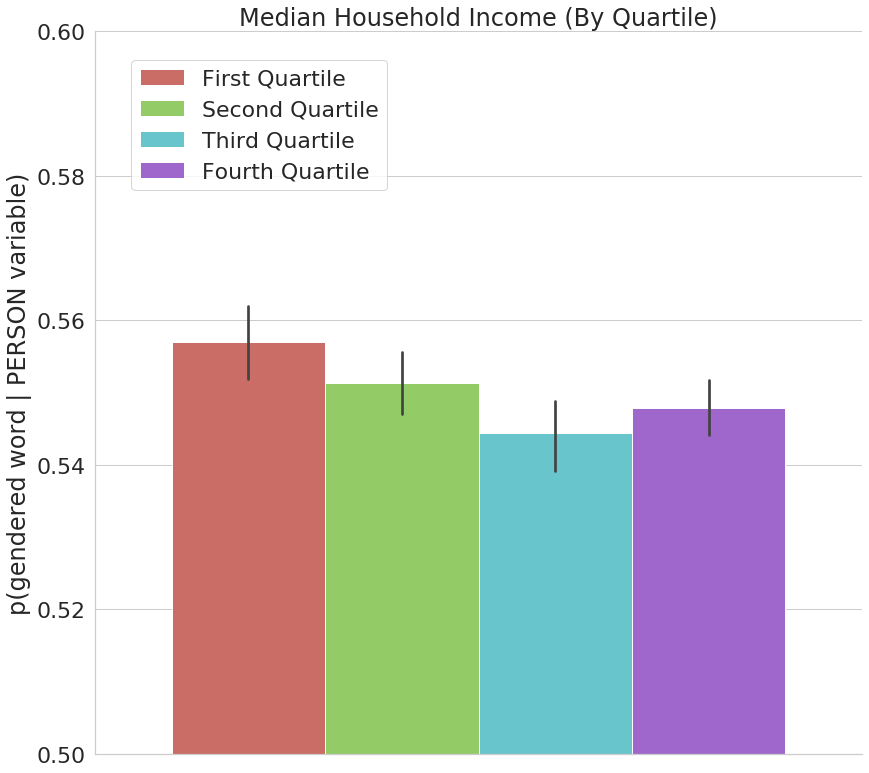

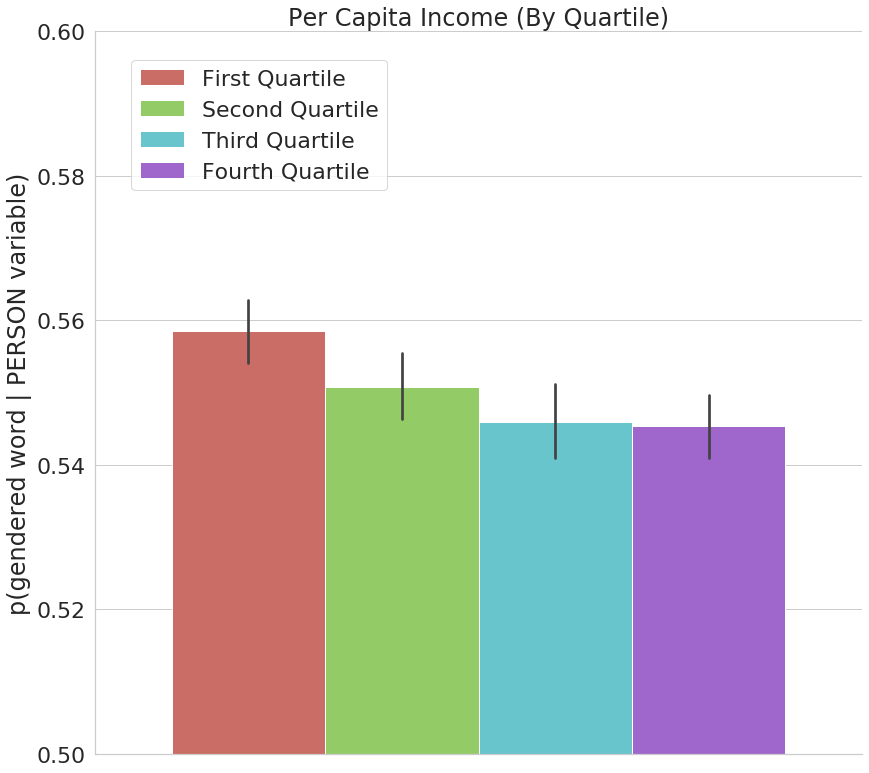

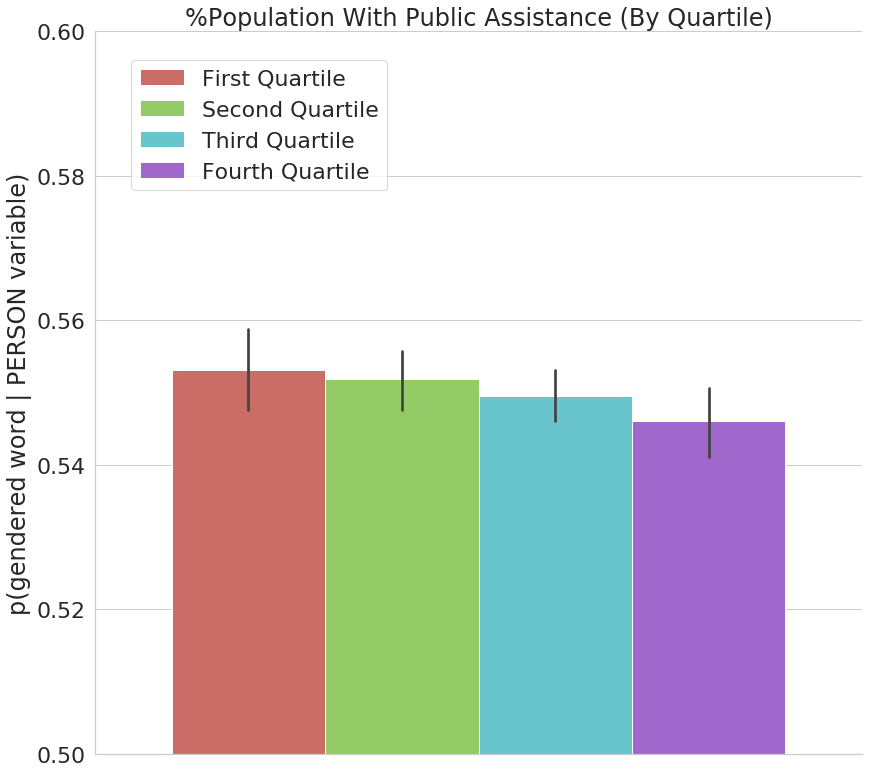

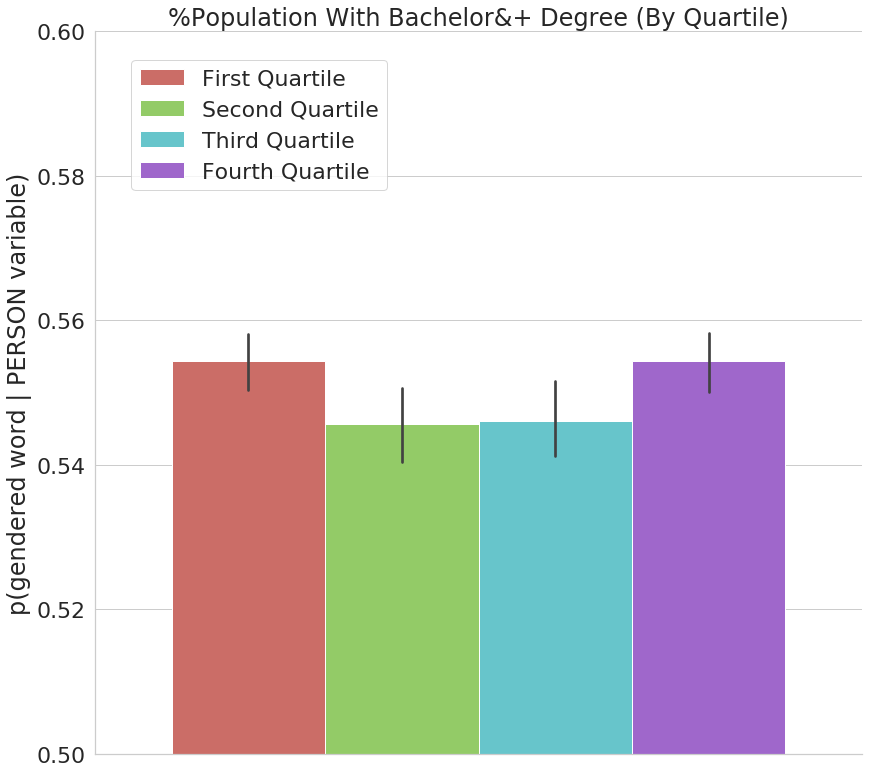

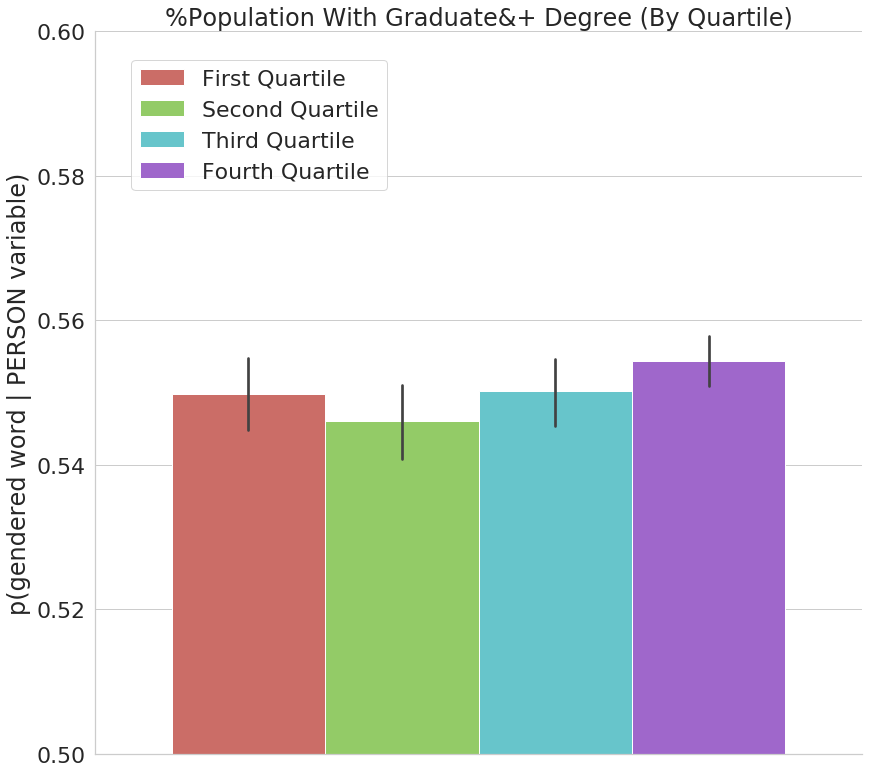

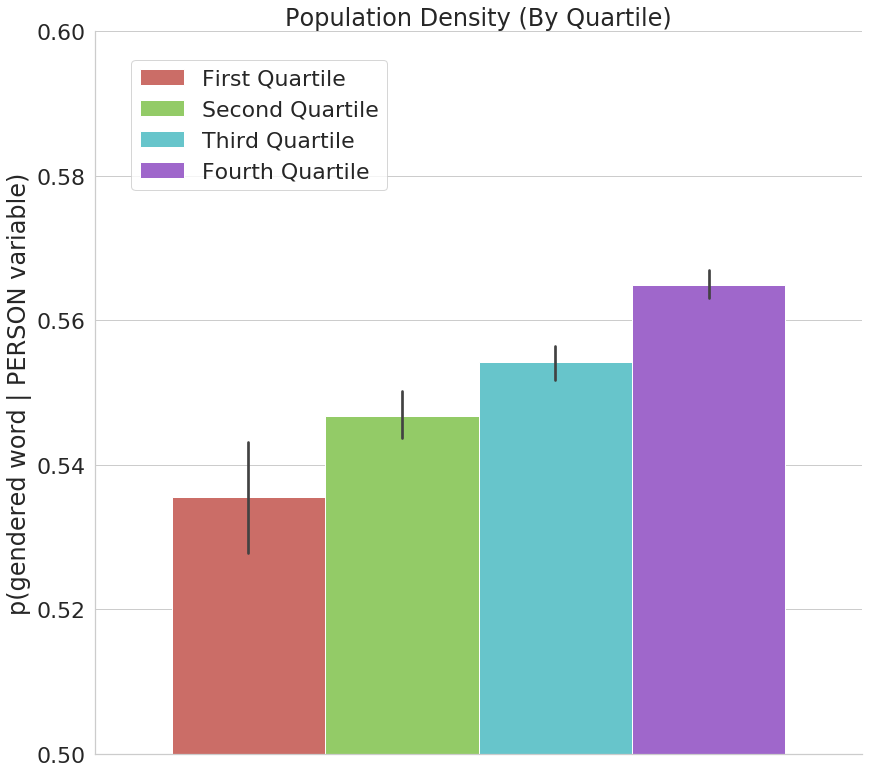

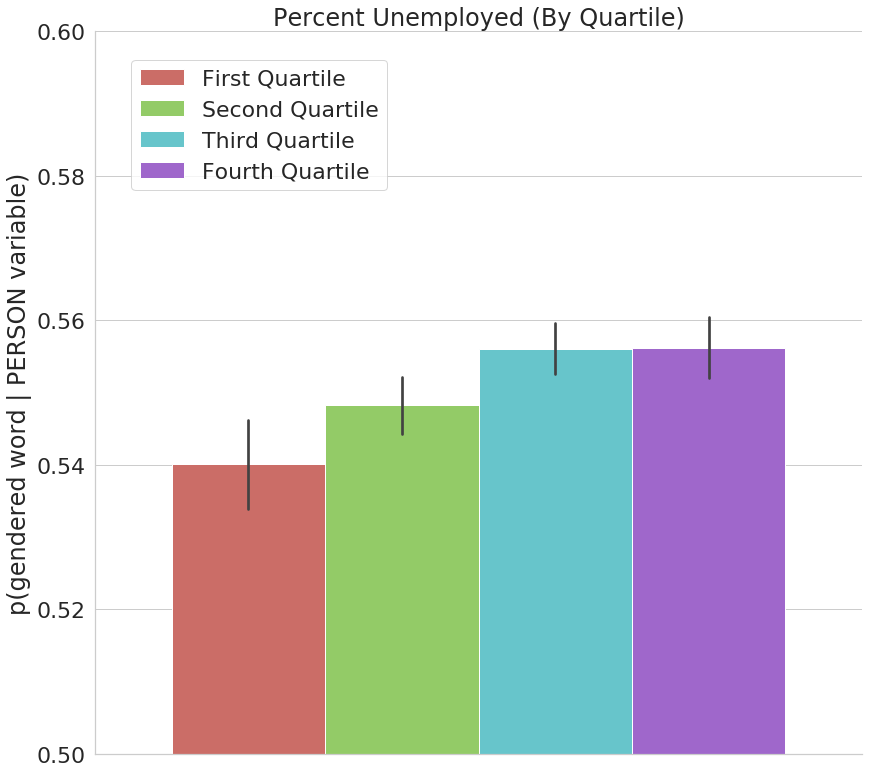

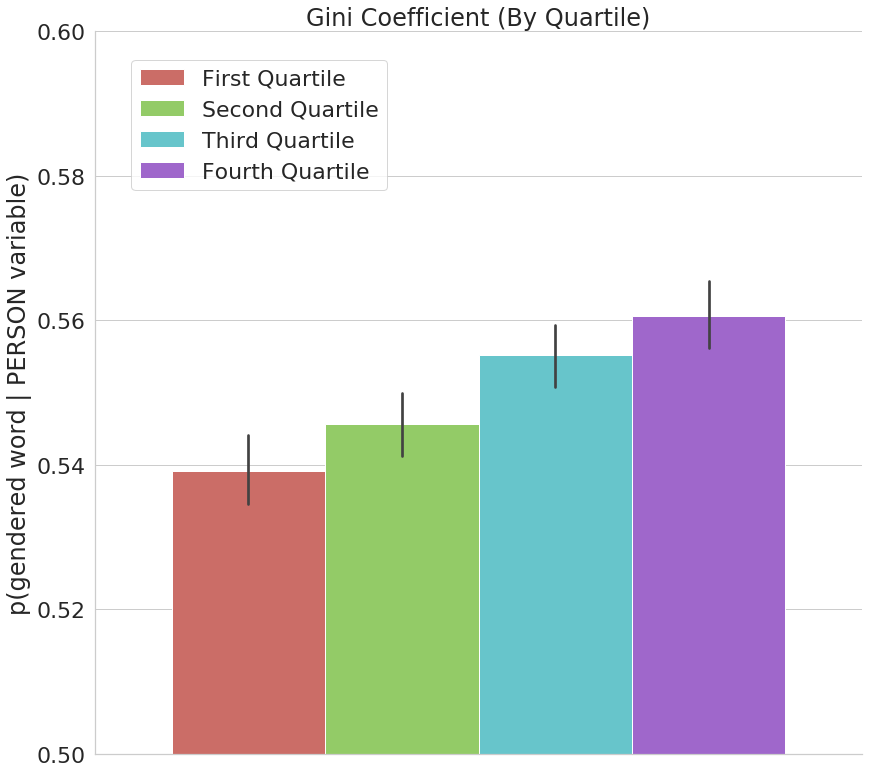

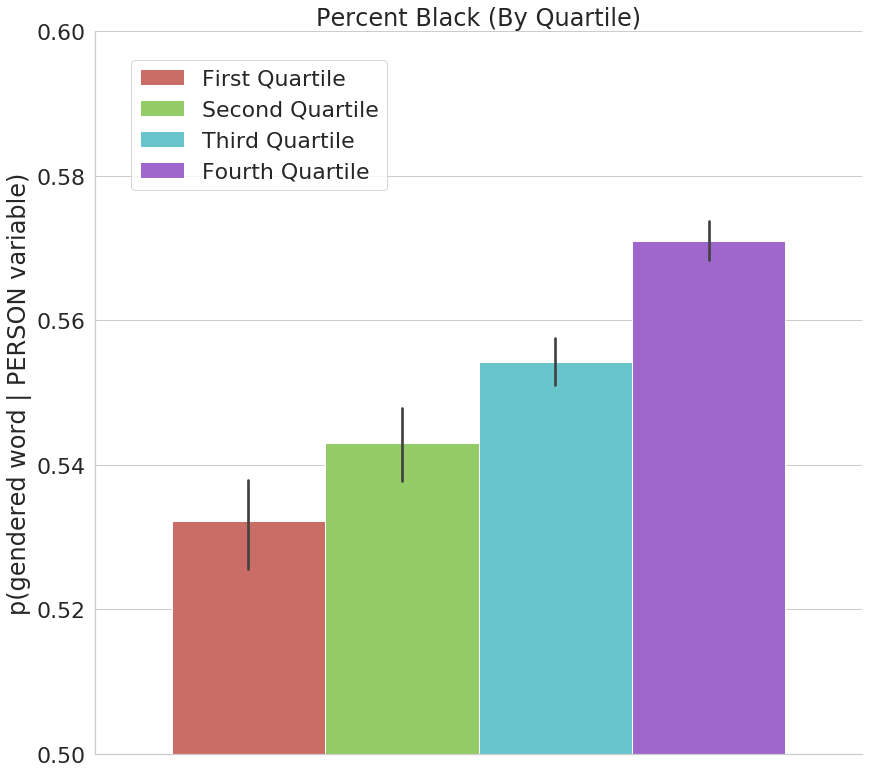

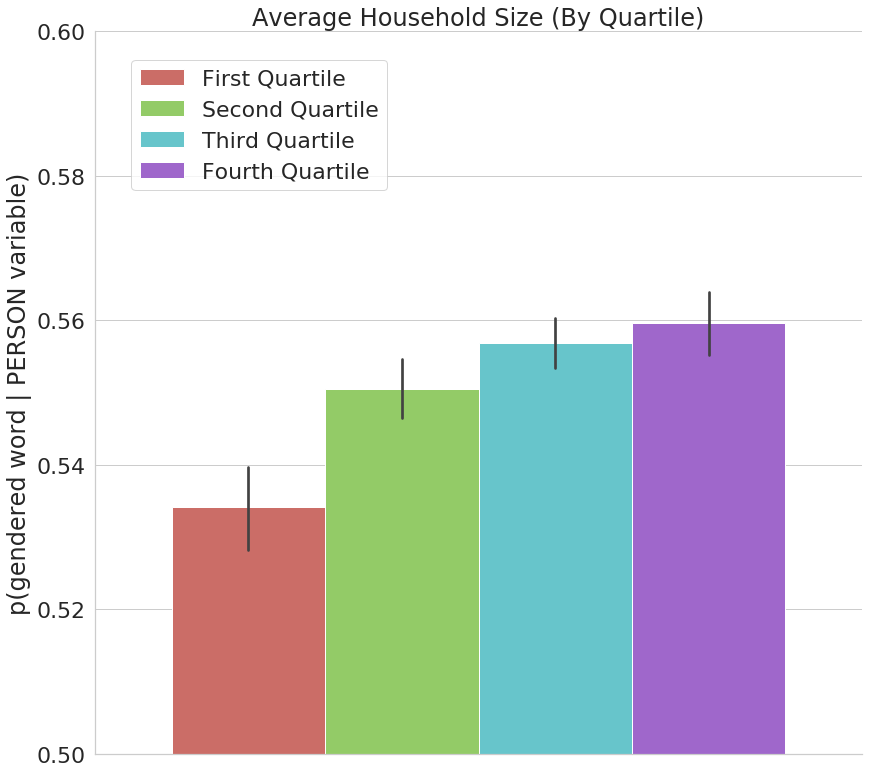

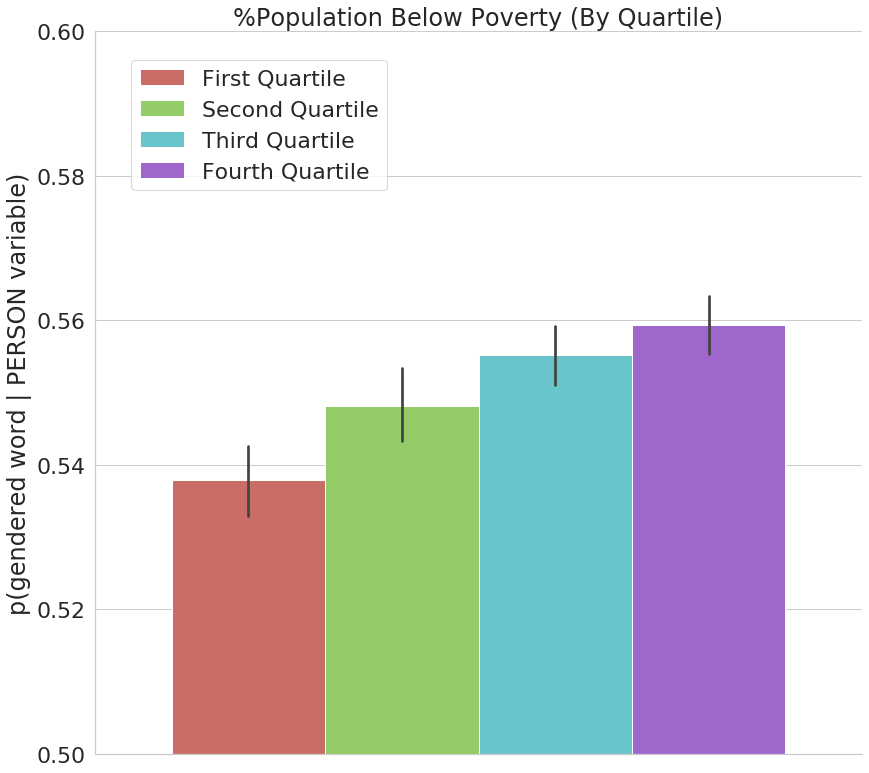

In [7]:
# FINAL PLOT FOR DUDE, CONTROLLED DT ONLY, ALL
# TWITTER SES
sns.set(font_scale=2, style="whitegrid")

df = pd.read_csv("acsdata-allyears-dude-new-singularplural-people.csv")
print(df.columns)
ses_cols = {"var_age_dependency_index": "Age Dependency Index (By Quartile)",
           "var_median_household_income": "Median Household Income (By Quartile)",
           "var_per_capita_income": "Per Capita Income (By Quartile)",
           "var_percent_households_with_public_assistance": "%Population With Public Assistance (By Quartile)",
           "var_percent_with_bachelorandhigher_25andolder": "%Population With Bachelor&+ Degree (By Quartile)",
           "var_percent_with_graduateandhigher_25andolder": "%Population With Graduate&+ Degree (By Quartile)",
           "POPDENSITY": "Population Density (By Quartile)",
           "var_percent_unemployed": "Percent Unemployed (By Quartile)",
           "var_gini": "Gini Coefficient (By Quartile)",
           "var_percent_black": "Percent Black (By Quartile)",
           "var_average_household_size": "Average Household Size (By Quartile)",
           "var_percent_below_poverty": "%Population Below Poverty (By Quartile)"}

# Gendered v. Non-Gendered
df['gendered'] = 0.0
df['non-gendered'] = 0.0
gendered = ['guy', 'man', 'bro', 'dude', 'girl', 'fella', 
           'dudettes', 'bros', 'guys', 'girls', 'dudes']
non_gendered = ['fam', 'buddy', 'dawg', 'pal', 'homie', 'comrade', 'person', 'individual', 'mate',
               'dawgs', 'peeps', 'folks', 'persons', 'comrades', 'buddies', 'pals', 'mates', 'homies', 'people']

for idx, row in df.iterrows():
    for term in gendered:
        df.at[idx, 'gendered'] += row[term]
    for term in non_gendered:
        df.at[idx, 'non-gendered'] += row[term]

# ### Population Density ###
usapd_df = pd.read_csv("USA_Population_Density.csv")
usapd_df = usapd_df[["ID", "LANDAREA", "TOTPOP_CY"]]
usapd_df['ID'] = usapd_df['ID'].astype(str)
usapd_df['ID'] = usapd_df['ID'].str[:-6]
usapd_df = usapd_df.groupby(["ID"],as_index=False).agg({'LANDAREA': 'sum', 'TOTPOP_CY': 'sum'})
usapd_df['POPDENSITY'] = usapd_df['TOTPOP_CY'] / usapd_df['LANDAREA']
usapd_df.rename(columns = {'ID':'FIPS'}, inplace = True)
usapd_df['FIPS'] = usapd_df['FIPS'].astype(int)
# ##########################

df = df.merge(usapd_df, on="FIPS", how="left")
df = df[['gendered', 'non-gendered'] + list(ses_cols.keys())]
df['gendered-non-gendered'] = df['gendered'] - df['non-gendered']

# Quartile Separation and LFDF construction
quartile_names = ["First Quartile", "Second Quartile", "Third Quartile", "Fourth Quartile"]
lfdf_data = []
for col in ses_cols:
    quartiles = df[col].quantile([0.25,0.5,0.75]).tolist()
    df[col + "_quartiles"] = ""
    df.loc[(df[col] <= quartiles[0]), col + "_quartiles"] = quartile_names[0]
    df.loc[(df[col] > quartiles[0]) & (df[col] <= quartiles[1]), col + "_quartiles"] = quartile_names[1]
    df.loc[(df[col] > quartiles[1]) & (df[col] <= quartiles[2]), col + "_quartiles"] = quartile_names[2]
    df.loc[(df[col] > quartiles[2]), col + "_quartiles"] = quartile_names[3]
    
    for idx, row in df.iterrows():
        # word, percentage, quartile, category
        if row[col + "_quartiles"] in quartile_names:
            lfdf_data.append({'word': '', 'percentage': row['gendered'], 'quartile':row[col + "_quartiles"], 'ses':col})
df = pd.DataFrame.from_dict(lfdf_data, orient='columns')
df['quartile'] = pd.Categorical(df['quartile'], quartile_names)

# Plotting
for col in ses_cols:
    print("Plotting", ses_cols[col])
    block_df = df[df['ses'] == col]
    block_df.sort_values(['word', 'quartile'])
    block_df.rename(columns = {'quartile':''}, inplace = True)
    
    fig = sns.catplot(x='word', y='percentage', hue='', data=block_df,
                     kind='bar', dodge=True, ci=95, palette="hls", legend = False, legend_out = False,
                     height=12, aspect=1)
    fig.set(xlabel='', ylabel='p(gendered word | PERSON variable)', title=ses_cols[col])
    
    plt.title(ses_cols[col])
    
    fig.fig.subplots_adjust(top=.88)
    fig.fig.legend(bbox_to_anchor = (0.3,0.75), loc='center')
    #plt.legend(loc="center right", bbox_to_anchor=(3.8,0.5), fontsize=30)
    plt.ylim(0.5, 0.6)#0.8-0.9
    plt.savefig('plots-final/dude-controlled-ses/' + col + '.pdf', bbox_inches='tight')

Reading csv...
Reformatting...



Computing probabilities...



Reading csvs...
Reformatting...



Plotting...


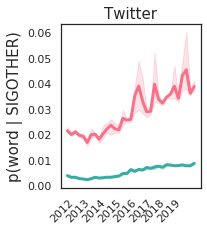

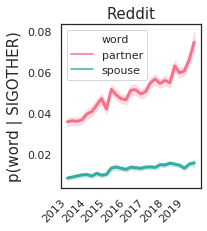

In [436]:
sns.set(style="white", font_scale=1)
# FINAL PLOT FOR TWITTER, PARTNER PRP, ALL OVER TIME

print("Reading csv...")
df = pd.read_csv("/shared/2/projects/dude/data/twitter-plot-partner/all-prp.txt", sep='\t',
                names=['STATEFP', 'COUNTYFP', 'variant', 'count', 'filename'])
timeaxisname = 'Time'
words_to_keep = ['partner', 'spouse']

# Reformatting
print("Reformatting...")
df['year'] = ''
df['month'] = ''
df['day'] = ''
df.loc[df['filename'].str.contains('gardenhose'), 'year'] = df['filename'].str[11:15]
df.loc[df['filename'].str.contains('gardenhose'), 'month'] = df['filename'].str[16:18]
df.loc[df['filename'].str.contains('gardenhose'), 'day'] = df['filename'].str[19:21]
df.loc[df['filename'].str.contains('decahose'), 'year'] = df['filename'].str[9:13]
df.loc[df['filename'].str.contains('decahose'), 'month'] = df['filename'].str[14:16]
df.loc[df['filename'].str.contains('decahose'), 'day'] = df['filename'].str[17:19]

df = df.groupby(["year", 'month', 'variant'],as_index=False).agg({'count': 'sum'})
df_totals = df.groupby(["year", 'month'],as_index=False).agg({'count': 'sum'})

for index, row in tqdm(df.iterrows(), total=len(df)):
    if int(row['month']) in range(1,4):
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '1-3 Mo'
    elif int(row['month']) in range(4,7):
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '4-6 Mo'
    elif int(row['month']) in range(7,10):
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '7-9 Mo'
    else:
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '9-12 Mo'
timeaxis_sorted = df[timeaxisname].sort_values().unique()

temp = []
for idx, x in enumerate(timeaxis_sorted):
    if '1-' in x: temp.append(x[0:4])
    else: temp.append('')
timeaxis_sorted = temp

# Compute Probabilities
print("Computing probabilities...")
df['percentage'] = 0.0
for idx, row in tqdm(df.iterrows(), total=len(df)):
    total = df_totals.loc[(df_totals['year'] == row['year']) &
                 (df_totals['month'] == row['month']), 'count']
    df.at[idx, 'percentage'] = row['count'] / total

# Plotting
df = df[df['variant'].isin(words_to_keep)]
df.sort_values(['variant'])
plt.figure(figsize=(2.5,3))
fig = sns.lineplot(x=timeaxisname, y="percentage", hue="variant", data=df,
                  hue_order=words_to_keep, palette="husl", linewidth=3)
ax = plt.gca()
ax.set_xticklabels(labels=timeaxis_sorted, rotation=45, ha='right')

fig.set_xlabel('')
fig.set_ylabel('p(word | SIGOTHER)', fontsize=15)
fig.axes.set_title("Twitter", fontsize=15)

fig.legend(loc='center right', bbox_to_anchor=(5, 0.5), ncol=1)
legend = fig.get_legend()
export_legend(legend, filename="plots-final/time-general/partner-legend.pdf")
legend.remove()

plt.savefig('plots-final/time-general/partner-Twitter.pdf', bbox_inches='tight')

# block_df_2 = df.groupby(['Community Group', 'time'], as_index=False).agg({'percentage': 'mean'})
# for c_g in block_df_2['Community Group'].unique():
#     values = block_df_2[block_df_2['Community Group'] == c_g].sort_values(by=['time'], ascending=True)['percentage'].tolist()
#     pr = pearsonr(range(len(values)), values)
#     print(c_g, pr)

# FINAL PLOT FOR REDDIT, PARTNER PRP, ALL OVER TIME

sns.set_style("white")
timeaxisname = 'Time'
words_to_keep = ['partner', 'spouse']

# Messy Read-ins
print("Reading csvs...")
df = pd.read_csv("partner-possessive-categories-withgeo-2.txt", sep='\t',
                names=['percentage', 'word', 'trial', 'year', 'month', 'subreddit', 'category'])
df = pd.concat([df[~df['category'].str.contains("sexuality")], df.loc[df['category'] == 'sexuality_asexual']])
df2 = pd.read_csv("partner-possessive-categories-heterovslgbt-2.txt", sep='\t',
                  names=['percentage', 'word', 'trial', 'year', 'month', 'subreddit', 'category'])
df = pd.concat([df, df2])
df = df[df['category'] == 'general']

# Reformatting
print("Reformatting...")
df[timeaxisname] = ''
df = df[df['word'].isin(words_to_keep)]
for index, row in tqdm(df.iterrows(), total=len(df)):
    if int(row['month']) in range(1,4):
         df.at[index, timeaxisname] = str(row['year']) + ' ' + '1-3 Mo'
    elif int(row['month']) in range(4,7):
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '4-6 Mo'
    elif int(row['month']) in range(7,10):
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '7-9 Mo'
    else:
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '9-12 Mo'
timeaxis_sorted = df[timeaxisname].sort_values().unique()

temp = []
for idx, x in enumerate(timeaxis_sorted):
    if '1-' in x: temp.append(x[0:4])
    else: temp.append('')
timeaxis_sorted = temp

# Plotting
print("Plotting...")
df.sort_values(['word'])
plt.figure(figsize=(2.5,3))
fig = sns.lineplot(x=timeaxisname, y="percentage", hue="word", data=df,
                  hue_order=words_to_keep, palette="husl", linewidth=3)
ax = plt.gca()
ax.set_xticklabels(labels=timeaxis_sorted, rotation=45, ha='right')

fig.set_xlabel('')
fig.set_ylabel('p(word | SIGOTHER)', fontsize=15)
fig.axes.set_title("Reddit", fontsize=15)

# fig.get_legend().remove()

plt.savefig('plots-final/time-general/partner-Reddit.pdf', bbox_inches='tight')

Reading csv...
Reformatting...
Gendered v. Non-Gendered formatting...



Computing probabilities...



Reading csvs...
Reformatting...


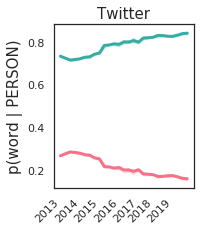

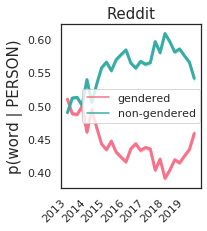

In [67]:
sns.set(style="white", font_scale=1)
# FINAL PLOT FOR TWITTER, DUDE CONTROLLED DT, ALL OVER TIME

print("Reading csv...")
df = pd.read_csv("/shared/2/projects/dude/data/twitter-plot-dude/all-1-plural-people.txt", sep='\t',
                names=['STATEFP', 'COUNTYFP', 'variant', 'count', 'filename'])
timeaxisname = 'Time'
gendered_legendname = 'Gender Signalling'
sns.set_style("white")

# Reformatting
print("Reformatting...")
df['year'] = ''
df['month'] = ''
df['day'] = ''
df.loc[df['filename'].str.contains('gardenhose'), 'year'] = df['filename'].str[11:15]
df.loc[df['filename'].str.contains('gardenhose'), 'month'] = df['filename'].str[16:18]
df.loc[df['filename'].str.contains('gardenhose'), 'day'] = df['filename'].str[19:21]
df.loc[df['filename'].str.contains('decahose'), 'year'] = df['filename'].str[9:13]
df.loc[df['filename'].str.contains('decahose'), 'month'] = df['filename'].str[14:16]
df.loc[df['filename'].str.contains('decahose'), 'day'] = df['filename'].str[17:19]

# Gendered v. Non-Gendered
print("Gendered v. Non-Gendered formatting...")
gendered = ['guy', 'man', 'bro', 'dude', 'girl', 'fella', 'dudes',
           'dudettes', 'bros', 'guys', 'girls']
non_gendered = ['fam', 'buddy', 'dawg', 'pal', 'homie', 'comrade', 'person', 'individual', 'mate',
               'dawgs', 'peeps', 'folks', 'persons', 'comrades', 'buddies', 'pals', 'mates', 'homies', 'people']

df[gendered_legendname] = 'gendered'
df.loc[df['variant'].isin(non_gendered), gendered_legendname] = 'non-gendered'
df = df.groupby(["year", 'month', gendered_legendname],as_index=False).agg({'count': 'sum'})
df_totals = df.groupby(["year", 'month'],as_index=False).agg({'count': 'sum'})

for index, row in tqdm(df.iterrows(), total=len(df)):
    if int(row['month']) in range(1,4):
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '1-3 Mo'
    elif int(row['month']) in range(4,7):
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '4-6 Mo'
    elif int(row['month']) in range(7,10):
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '7-9 Mo'
    else:
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '9-12 Mo'
timeaxis_sorted = df[timeaxisname].sort_values().unique()

temp = []
for idx, x in enumerate(timeaxis_sorted):
    if '1-' in x: temp.append(x[0:4])
    else: temp.append('')
timeaxis_sorted = temp

# Compute Probabilities
print("Computing probabilities...")
df['percentage'] = 0.0
for idx, row in tqdm(df.iterrows(), total=len(df)):
    total = df_totals.loc[(df_totals['year'] == row['year']) &
                 (df_totals['month'] == row['month']), 'count']
    df.at[idx, 'percentage'] = row['count'] / total

# Plotting
plt.figure(figsize=(2.5,3))
fig = sns.lineplot(x=timeaxisname, y="percentage", hue=gendered_legendname, data=df,
                  hue_order=['gendered', 'non-gendered'], palette="husl", linewidth=3)
ax = plt.gca()
ax.set_xticklabels(labels=timeaxis_sorted, rotation=45, ha='right')

fig.set_xlabel('')
fig.set_ylabel('p(word | PERSON)', fontsize=15)
fig.axes.set_title("Twitter", fontsize=15)
fig.get_legend().remove()

plt.savefig('plots-final/time-general/dude-Twitter.pdf', bbox_inches='tight')

# FINAL PLOT FOR REDDIT, DUDE CONTROLLED DT, ALL OVER TIME
sns.set_style("white")
timeaxisname = 'Time'
gendered_legendname = 'Gender Signalling'

# Messy Read-ins
print("Reading csvs...")
df = pd.read_csv("repercent3.txt",
                sep='\t', names=['percentage', 'word', 'trial', 'year', 'month', 'category', 'num_valid'])
df = df[df['category'] == 'general']

# Gendered v. Non-Gendered
gendered = ['guy', 'man', 'bro', 'dude', 'girl', 'fella','dudes'
           'dudettes', 'bros', 'guys', 'girls']
non_gendered = ['fam', 'buddy', 'dawg', 'pal', 'homie', 'comrade', 'person', 'individual', 'mate'
               'dawgs', 'peeps', 'folks', 'persons', 'comrades', 'buddies', 'pals', 'mates', 'homies', 'people']

df[gendered_legendname] = 'gendered'
df.loc[df['word'].isin(non_gendered), gendered_legendname] = 'non-gendered'
df = df.groupby(['trial', 'year', 'month', 'category', gendered_legendname],as_index=False).agg({'percentage': 'sum'})

# Reformatting
print("Reformatting...")
df[timeaxisname] = ''
for index, row in tqdm(df.iterrows(), total=len(df)):
    if int(row['month']) in range(1,4):
         df.at[index, timeaxisname] = str(row['year']) + ' ' + '1-3 Mo'
    elif int(row['month']) in range(4,7):
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '4-6 Mo'
    elif int(row['month']) in range(7,10):
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '7-9 Mo'
    else:
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '9-12 Mo'
timeaxis_sorted = df[timeaxisname].sort_values().unique()

temp = []
for idx, x in enumerate(timeaxis_sorted):
    if '1-' in x: temp.append(x[0:4])
    else: temp.append('')
timeaxis_sorted = temp

# Plotting
plt.figure(figsize=(2.5,3))
fig = sns.lineplot(x=timeaxisname, y="percentage", hue=gendered_legendname, data=df,
                  hue_order=['gendered', 'non-gendered'], palette="husl", linewidth=3)
ax = plt.gca()
ax.set_xticklabels(labels=timeaxis_sorted, rotation=45, ha='right')

fig.set_xlabel('')
fig.set_ylabel('p(word | PERSON)', fontsize=15)
fig.axes.set_title("Reddit", fontsize=15)

fig.legend(loc='center right', bbox_to_anchor=(1.035, 0.5), ncol=1)
# legend = fig.get_legend()
# export_legend(legend, filename="plots-final/time-general/dude-legend.pdf")
# legend.remove()

plt.savefig('plots-final/time-general/dude-Reddit.pdf', bbox_inches='tight')    

In [3]:
# FINAL PLOT FOR DUDE, CONTROLLED USAGES ONLY, OVER TIME
# REDDIT CATEGORIES
# PART ONE

timeaxisname = 'Time'
gendered_legendname = 'Gender Signalling'

# Messy Read-ins and Pre-Formatting

df = pd.read_csv("repercent3.txt",
                sep='\t', names=['percentage', 'word', 'trial', 'year', 'month', 'category', 'num_valid'])
df = df[df['category']!='geo']
df = df[df['category']!='politics_general']
df = df[df['category']!='religion_other']
df = df[df['category']!='religion_eastern']
df.loc[df['category'] == 'gender_other', 'category'] = 'gender_Gender Critical'

### SUNDAY CHANGES ###
df.loc[df['category'] == 'politics_left', 'category'] = 'politics_liberal' 
df.loc[df['category'] == 'politics_right', 'category'] = 'politics_conservative' 
df.loc[df['category'] == 'sexuality_heteronormative', 'category'] = 'sexuality_heterosexual' 
######################

### Inclusivity Changes ###
df = df[df['category'] != 'politics_libertarian']
df = df[df['category'] != 'gender_Gender Critical']
df = df[df['category'] != 'sexuality_asexual']
df.loc[df['category'] == 'sexuality_lgbtq', 'category'] = 'sexuality_LGBT+' 
##########################

# Gendered v. Non-Gendered
gendered = ['guy', 'man', 'bro', 'dude', 'girl', 'fella', 
           'dudettes', 'bros', 'guys', 'girls', 'dudes']
non_gendered = ['fam', 'buddy', 'dawg', 'pal', 'homie', 'comrade', 'person', 'individual', 'mate',
               'dawgs', 'peeps', 'folks', 'persons', 'comrades', 'buddies', 'pals', 'mates', 'homies', 'people']

df[gendered_legendname] = 'gendered'
df.loc[df['word'].isin(non_gendered), gendered_legendname] = 'non-gendered'
df = df.groupby(['trial', 'year', 'month', 'category', gendered_legendname],as_index=False).agg({'percentage': 'sum'})

# Reformatting
print("Reformatting...")
df[timeaxisname] = ''
for index, row in tqdm(df.iterrows(), total=len(df)):
    if int(row['month']) in range(1,7):
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '1-6 Mo'
    else:
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '7-12 Mo'
timeaxis_sorted = df[timeaxisname].sort_values().unique()

temp = []
for idx, x in enumerate(timeaxis_sorted):
    if '1-' in x: temp.append(x[0:4])
    else: temp.append('')
timeaxis_sorted = temp

# Cleanup Filtering
df = df[['percentage', gendered_legendname, 'category', 'trial', timeaxisname]]

Reformatting...


  0%|          | 0/165156 [00:00<?, ?it/s]

Plotting for Block sexuality
Plotting for Block gender
Plotting for Block religion
Plotting for Block politics
Plotting for Block age
                  category  pearsonr        p-value
0                  age_old  0.005308   9.563129e-01
1                age_young -0.243299   1.086244e-33
2               gender_men -0.140184   2.303745e-04
3       gender_transgender -0.463411  1.320764e-110
4             gender_women -0.548941   0.000000e+00
5                  general -0.485359   0.000000e+00
6    politics_conservative  0.130218   4.001367e-21
7         politics_liberal  0.428417   0.000000e+00
8    religion_christianity  0.256543   1.378122e-50
9         religion_general  0.266277   2.497132e-21
10          religion_islam -0.147674   1.372972e-03
11        religion_judaism -0.253448   1.171049e-04
12   religion_nonbelievers  0.397049  1.023395e-140
13         sexuality_LGBT+  0.147282   1.838505e-14
14  sexuality_heterosexual -0.130398   6.123438e-53


<Figure size 432x288 with 0 Axes>

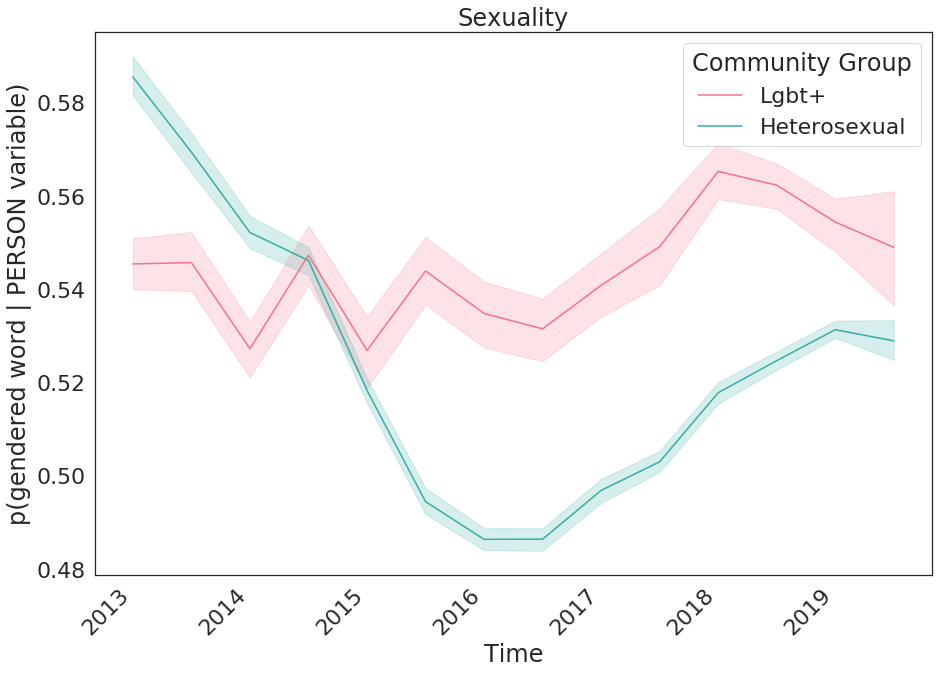

<Figure size 432x288 with 0 Axes>

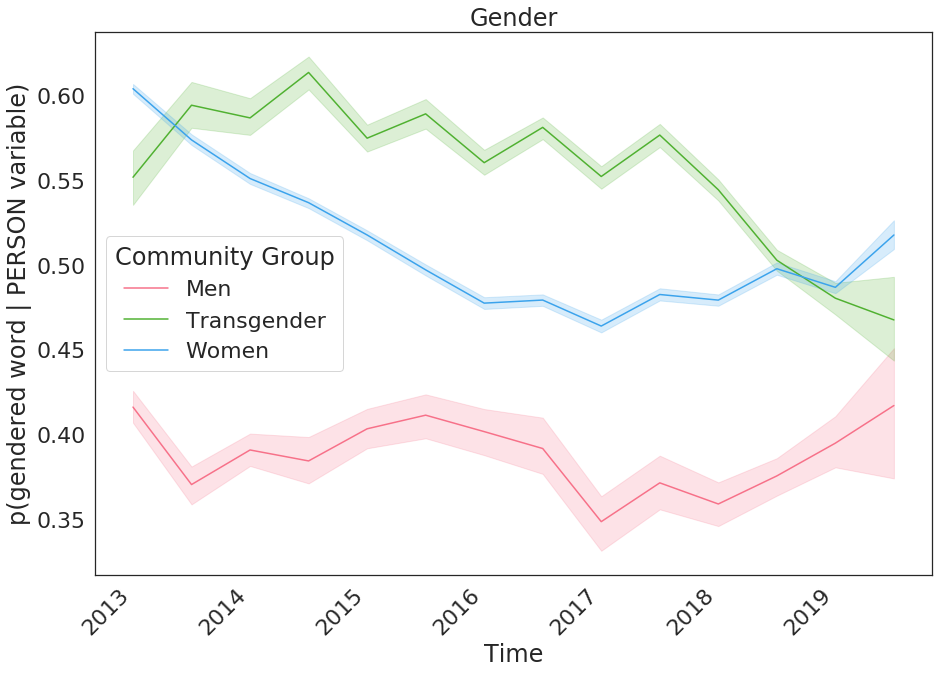

<Figure size 432x288 with 0 Axes>

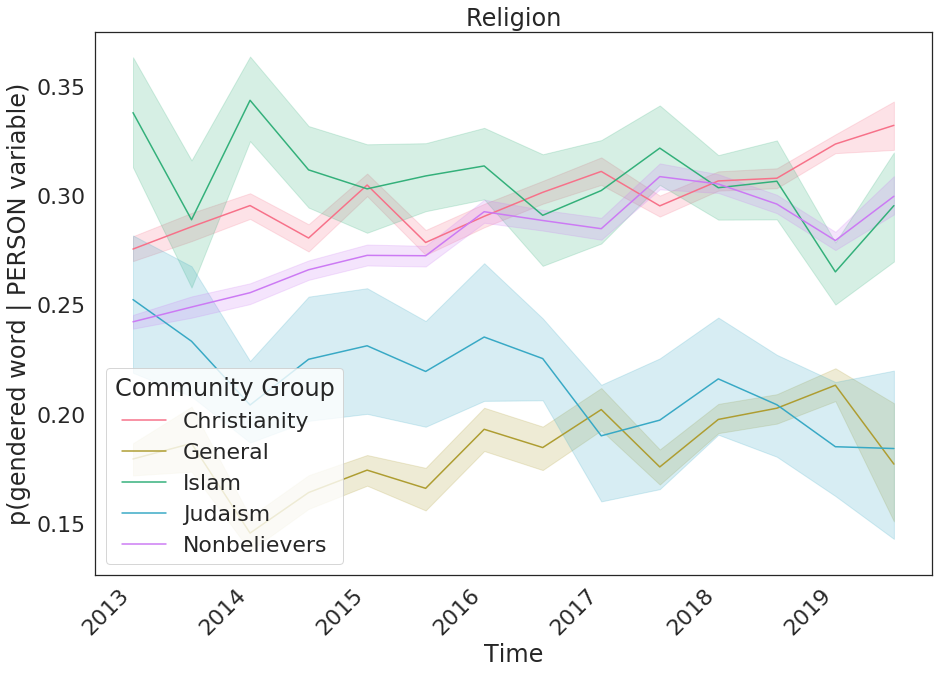

<Figure size 432x288 with 0 Axes>

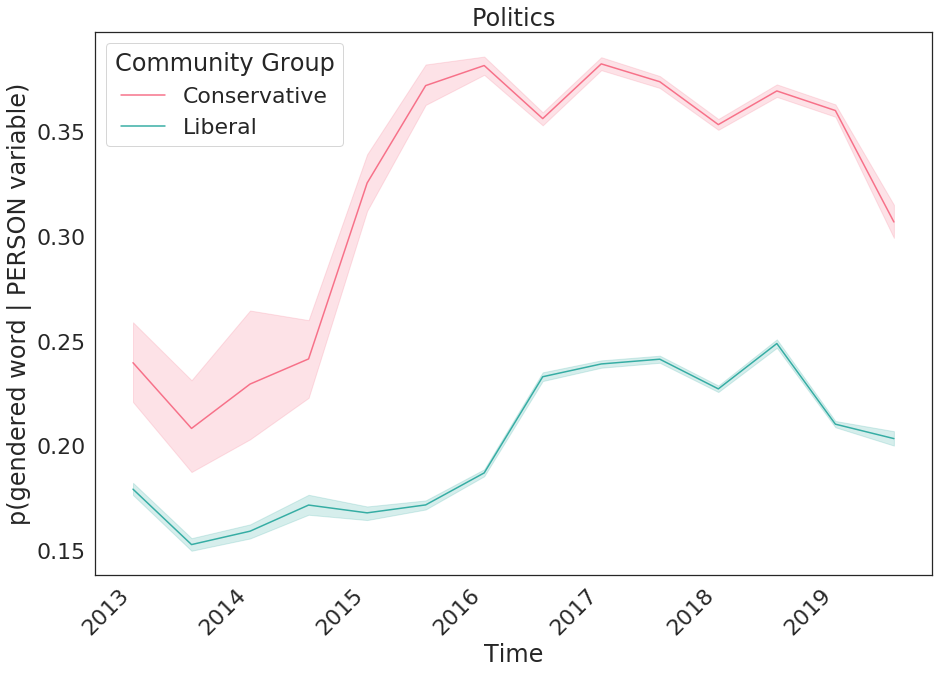

<Figure size 432x288 with 0 Axes>

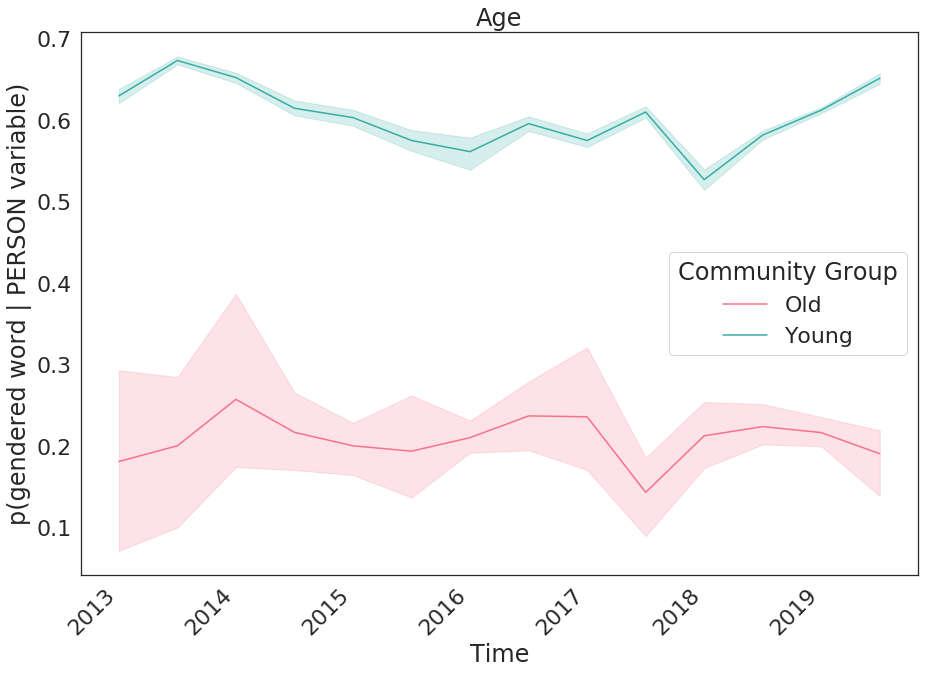

In [4]:
# FINAL PLOT FOR DUDE, CONTROLLED USAGES ONLY, OVER TIME
# REDDIT CATEGORIES
# PART TWO
sns.set_style("white")

# Plotting Goodness
for block in ['sexuality', 'gender', 'religion', 'politics', 'age']:
    print("Plotting for Block", block)
    block_df = df[(df['category'].str.contains(block))]
    block_df = block_df[block_df[gendered_legendname] == 'gendered']
    
    # Sexuality
    block_df = block_df[block_df['category'] != 'sexuality_asexual']
    # Gender
    ## Nothing I guess
    # Politics
    #block_df = block_df[block_df['category'] != 'politics_general']
    # Religion
    #block_df = block_df[block_df['category'] != 'religion_eastern']
    # block_df = block_df[block_df['word'] != 'spouse']
    
    for cat in block_df['category'].unique():
        block_df.loc[block_df['category'] == cat, 'category'] = (cat[len(block)+1:]).capitalize()
    block_df.rename(columns = {'category':'Community Group'}, inplace = True)
    
    plt.figure()
    fig, ax = plt.subplots(figsize=(15,10))
    fig = sns.lineplot(ax=ax, x=timeaxisname, y="percentage", hue="Community Group", data=block_df,
                  palette="husl")
    fig.set(ylabel='p(gendered word | PERSON variable)', title=block.capitalize())

    ax = plt.gca()
    ax.set_xticklabels(labels=timeaxis_sorted, rotation=45, ha='right')
    plt.savefig('plots-final/dude-controlled-time/' + block + '.pdf', bbox_inches='tight')

# Correlations Goodness
df_ordered_data = []
time_in_order = list(df[timeaxisname].sort_values().unique())
for idx, row in df.iterrows():
    if row[gendered_legendname] == 'gendered':
        df_ordered_data.append({'category': row['category'], 'time': time_in_order.index(row[timeaxisname]), 'percentage': row['percentage']})
df_ordered = pd.DataFrame.from_dict(df_ordered_data, orient='columns')

df_correlations_data = []
for category in df_ordered['category'].unique():
    pr = pearsonr(df_ordered[df_ordered['category'] == category]['percentage'], df_ordered[df_ordered['category'] == category]['time'])
    df_correlations_data.append({'category': category, 'pearsonr': pr[0], 'p-value':pr[1]})
df_correlations = pd.DataFrame.from_dict(df_correlations_data, orient='columns')

pd.set_option('display.max_rows', None)
df_correlations = df_correlations.sort_values('category')
print(df_correlations)
pd.set_option('display.max_rows', 5)

In [10]:
df = pd.read_csv("acsdata-allyears-dude-new-singularplural-people.csv")

### Population Density ###
usapd_df = pd.read_csv("USA_Population_Density.csv")
usapd_df = usapd_df[["ID", "LANDAREA", "TOTPOP_CY"]]
usapd_df['ID'] = usapd_df['ID'].astype(str)
usapd_df['ID'] = usapd_df['ID'].str[:-6]
usapd_df = usapd_df.groupby(["ID"],as_index=False).agg({'LANDAREA': 'sum', 'TOTPOP_CY': 'sum'})
usapd_df['POPDENSITY'] = usapd_df['TOTPOP_CY'] / usapd_df['LANDAREA']
usapd_df.rename(columns = {'ID':'FIPS'}, inplace = True)
usapd_df['FIPS'] = usapd_df['FIPS'].astype(int)
df = df.merge(usapd_df, on="FIPS", how="left")
##########################

# Gendered v. Non-Gendered
gendered = ['guy', 'man', 'bro', 'dude', 'girl', 'fella', 
           'dudettes', 'bros', 'guys', 'girls', 'dudes']
non_gendered = ['fam', 'buddy', 'dawg', 'pal', 'homie', 'comrade', 'person', 'individual', 'mate',
               'dawgs', 'peeps', 'folks', 'persons', 'comrades', 'buddies', 'pals', 'mates', 'homies', 'people']

df['gendered'] = 0.0
df['non_gendered'] = 0.0
for word in gendered + non_gendered:
    if word in df.columns and word in gendered:
        df['gendered'] += df[word]
    if word in df.columns and word in non_gendered:
        df['non_gendered'] += df[word]

for word in gendered + non_gendered:
    if word in df.columns:
        print(scipy.stats.normaltest(df[word]))
print(scipy.stats.normaltest(df['gendered']))
print(scipy.stats.normaltest(df['non_gendered']))

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

ses_cols = {"var_age_dependency_index": "Age Dependency Index (By Quartile)",
           "var_median_household_income": "Median Household Income (By Quartile)",
           "var_per_capita_income": "Per Capita Income (By Quartile)",
           "var_percent_households_with_public_assistance": "%Population With Public Assistance (By Quartile)",
           "var_percent_with_bachelorandhigher_25andolder": "%Population With Bachelor&+ Degree (By Quartile)",
           "var_percent_with_graduateandhigher_25andolder": "%Population With Graduate&+ Degree (By Quartile)",
           "POPDENSITY": "Population Density (By Quartile)",
           "var_percent_unemployed": "Percent Unemployed (By Quartile)",
           "var_gini": "Gini Coefficient (By Quartile)",
           "var_percent_black": "Percent Black (By Quartile)",
           "var_average_household_size": "Average Household Size (By Quartile)",
           "var_percent_below_poverty": "%Population Below Poverty (By Quartile)"}

df2 = df[['gendered'] + list(ses_cols.keys())]

rho = df2.corr(method='pearson')
rho = rho.round(2)
pval = calculate_pvalues(df2) # toto_tico's answer
# create three masks
r1 = rho.applymap(lambda x: '{}*'.format(x))
r2 = rho.applymap(lambda x: '{}**'.format(x))
r3 = rho.applymap(lambda x: '{}***'.format(x))
# apply them where appropriate
rho = rho.mask(pval<=0.1,r1)
rho = rho.mask(pval<=0.05,r2)
rho = rho.mask(pval<=0.01,r3)

pd.set_option('display.max_rows', 500)
rho

NormaltestResult(statistic=2065.301305681753, pvalue=0.0)
NormaltestResult(statistic=3011.10657607087, pvalue=0.0)
NormaltestResult(statistic=4137.793479747007, pvalue=0.0)
NormaltestResult(statistic=4863.261273826611, pvalue=0.0)
NormaltestResult(statistic=1227.5120521649085, pvalue=2.812837462377871e-267)
NormaltestResult(statistic=6313.529309058451, pvalue=0.0)
NormaltestResult(statistic=8795.38448045754, pvalue=0.0)
NormaltestResult(statistic=5515.433251295472, pvalue=0.0)
NormaltestResult(statistic=5620.95054544662, pvalue=0.0)
NormaltestResult(statistic=4371.713521323025, pvalue=0.0)
NormaltestResult(statistic=4122.005153889218, pvalue=0.0)
NormaltestResult(statistic=5758.192190612857, pvalue=0.0)
NormaltestResult(statistic=8585.907731997282, pvalue=0.0)
NormaltestResult(statistic=4733.755002704375, pvalue=0.0)
NormaltestResult(statistic=4271.912010480701, pvalue=0.0)
NormaltestResult(statistic=4854.727501478369, pvalue=0.0)
NormaltestResult(statistic=10323.30132499377, pvalue=0.

gendered  \
gendered                                         1.0***   
var_age_dependency_index                        -0.1***   
var_median_household_income                    -0.04***   
var_per_capita_income                          -0.07***   
var_percent_households_with_public_assistance     -0.04   
var_percent_with_bachelorandhigher_25andolder      -0.0   
var_percent_with_graduateandhigher_25andolder      0.03   
POPDENSITY                                         0.02   
var_percent_unemployed                          0.07***   
var_gini                                        0.13***   
var_percent_black                               0.18***   
var_average_household_size                      0.12***   
var_percent_below_poverty                       0.08***   

                                              var_age_dependency_index  \
gendered                                                       -0.1***   
var_age_dependency_index                                        1.0***   
var_median_household_income                                   -0.21***   
var_per_capita_income                                         -0.09***   
var_percent_households_with_public_assistance                  -0.05**   
var_percent_with_bachelorandhigher_25andolder                 -0.32***   
var_percent_with_graduateandhigher_25andolder                 -0.37***   
POPDENSITY                                                    -0.16***   
var_percent_unemployed                                        -0.08***   
var_gini                                                      -0.08***   
var_percent_black                                             -0.23***   
var_average_household_size                                    -0.22***   
var_percent_below_poverty                                     -0.08***   

                                              var_median_household_income  \
gendered                                                         -0.04***   
var_age_dependency_index                                         -0.21***   
var_median_household_income                                        1.0***   
var_per_capita_income                                             0.89***   
var_percent_households_with_public_assistance                    -0.27***   
var_percent_with_bachelorandhigher_25andolder                     0.65***   
var_percent_with_graduateandhigher_25andolder                     0.57***   
POPDENSITY                                                        0.15***   
var_percent_unemployed                                           -0.52***   
var_gini                                                         -0.43***   
var_percent_black                                                -0.25***   
var_average_household_size                                        0.07***   
var_percent_below_poverty                                        -0.77***   

                                              var_per_capita_income  \
gendered                                                   -0.07***   
var_age_dependency_index                                   -0.09***   
var_median_household_income                                 0.89***   
var_per_capita_income                                        1.0***   
var_percent_households_with_public_assistance               -0.3***   
var_percent_with_bachelorandhigher_25andolder               0.73***   
var_percent_with_graduateandhigher_25andolder               0.65***   
POPDENSITY                                                  0.23***   
var_percent_unemployed                                     -0.54***   
var_gini                                                   -0.19***   
var_percent_black                                          -0.23***   
var_average_household_size                                 -0.21***   
var_percent_below_poverty                                  -0.75***   

                                              var_percent_households_with_public_assistance  \
gendered      

Plotting for Block gender
Plotting for Block sexuality
['guy', 'man', 'bro', 'dude', 'mate', 'fam', 'buddy', 'dawg', 'pal', 'homie', 'comrade', 'fella', 'girl', 'person', 'individual', 'dawgs', 'dudes', 'peeps', 'folks', 'dudettes', 'persons', 'bros', 'guys', 'girls', 'comrades', 'buddies', 'pals', 'mates', 'homies', 'people']
Plotting for Block gender
Plotting for Block sexuality
Reformatting...



Plotting for Block sexuality
Plotting for Block gender
                  category  pearsonr        p-value
0                  age_old  0.005308   9.563129e-01
1                age_young -0.243299   1.086244e-33
16             gender_TERF  0.196012   5.804220e-07
2               gender_men -0.140184   2.303745e-04
3       gender_transgender -0.463411  1.320764e-110
4             gender_women -0.548941   0.000000e+00
5                  general -0.485359   0.000000e+00
6    politics_conservative  0.130218   4.001367e-21
7         politics_liberal  0.428417   0.000000e+00
8    religion_christianity  0.256543   1.378122e-50
9         religion_general  0.266277   2.497132e-21
10          religion_islam -0.147674   1.372972e-03
11        religion_judaism -0.253448   1.171049e-04
12   religion_nonbelievers  0.397049  1.023395e-140
13         sexuality_LGBT+  0.147282   1.838505e-14
14       sexuality_asexual  0.034851   6.349196e-01
15  sexuality_heterosexual -0.130398   6.123438e-53


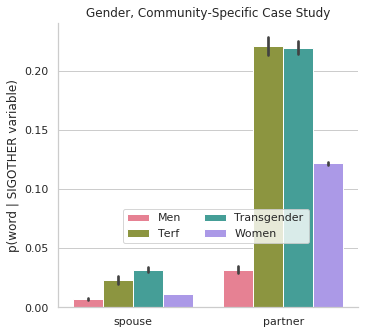

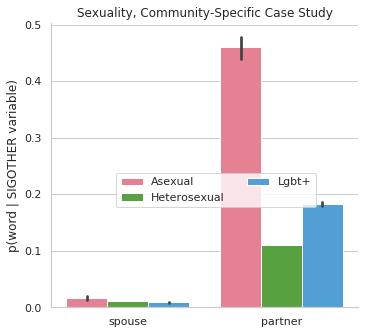

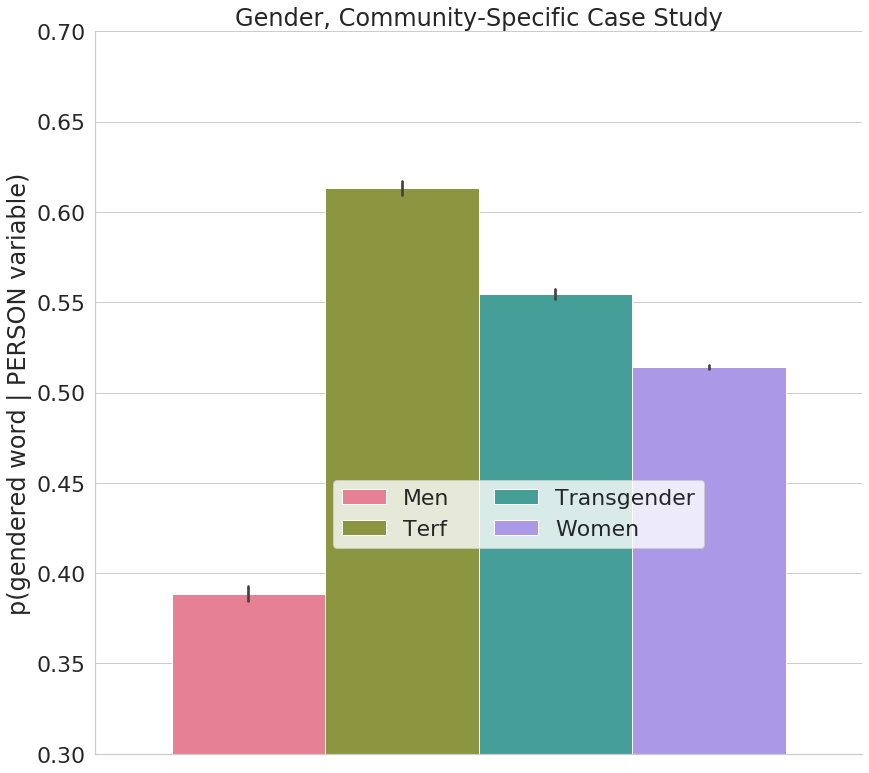

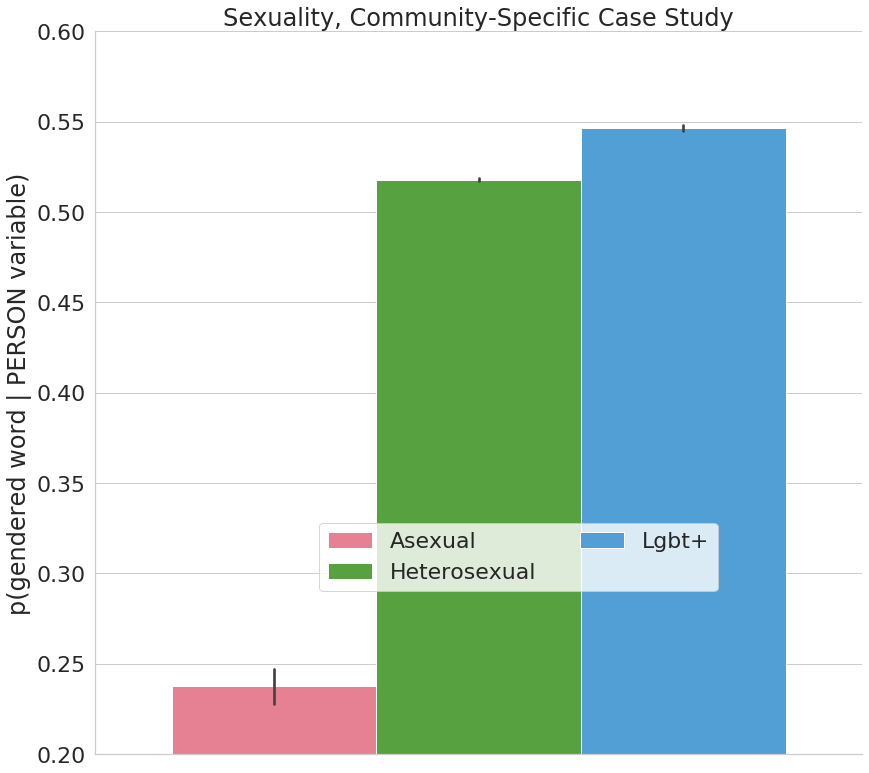

<Figure size 432x288 with 0 Axes>

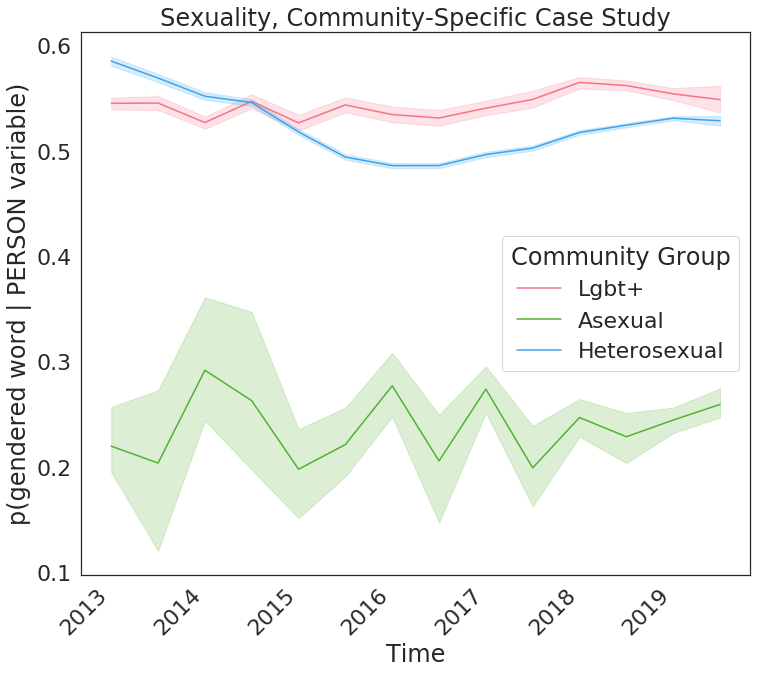

<Figure size 432x288 with 0 Axes>

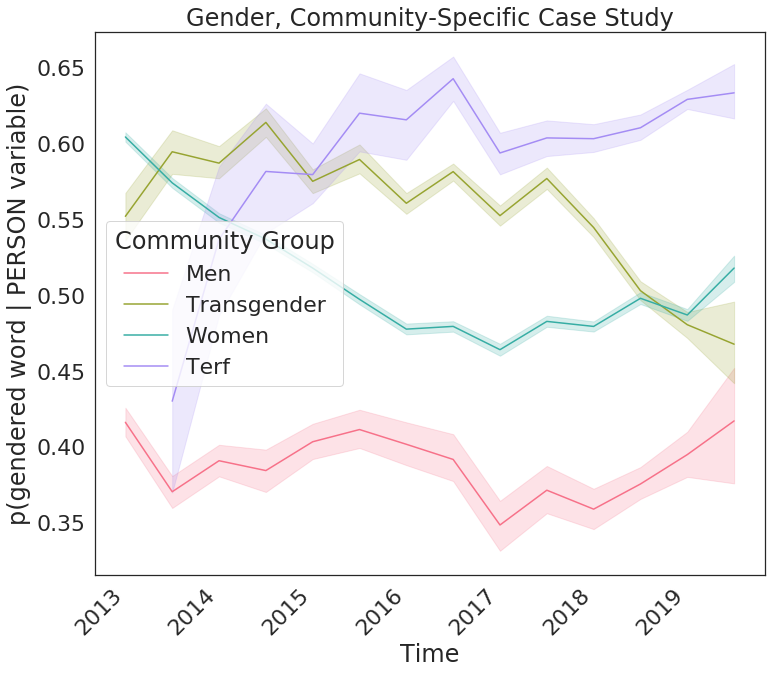

In [138]:
######## CASE STUDY
sns.set(style="whitegrid")

df = pd.read_csv("partner-possessive-categories-withgeo-2.txt", sep='\t',
                names=['percentage', 'word', 'trial', 'year', 'month', 'subreddit', 'category'])
df = pd.concat([df[~df['category'].str.contains("sexuality")], df.loc[df['category'] == 'sexuality_asexual']])
df2 = pd.read_csv("partner-possessive-categories-heterovslgbt-2.txt", sep='\t',
                  names=['percentage', 'word', 'trial', 'year', 'month', 'subreddit', 'category'])
df = pd.concat([df, df2])
df = df[df['word'].isin(['partner', 'spouse'])]

df.loc[df['category'] == 'gender_other', 'category'] = 'gender_TERF'

### SUNDAY CHANGES ###
df.loc[df['category'] == 'politics_left', 'category'] = 'politics_liberal' 
df.loc[df['category'] == 'politics_right', 'category'] = 'politics_conservative' 
df.loc[df['category'] == 'sexuality_heteronormative', 'category'] = 'sexuality_heterosexual' 
######################

### Inclusivity Changes ###
df.loc[df['category'] == 'sexuality_lgbtq', 'category'] = 'sexuality_LGBT+' 
##########################

for block in [ 'gender', 'sexuality']:
    print("Plotting for Block", block)
    block_df = df[df['category'].str.contains(block)]
    
    for cat in block_df['category'].unique():
        block_df.loc[block_df['category'] == cat, 'category'] = (cat[len(block)+1:]).capitalize()
    block_df.rename(columns = {'category':'Community Group'}, inplace = True)
    
    ###
    block_df = block_df.sort_values(['word', 'Community Group'], ascending=[False, True]).reset_index(drop=True)
    ###
    
    fig = sns.catplot(x='word', y='percentage', hue='Community Group', data=block_df,
        kind='bar', dodge=True, ci=95, palette="husl", legend = False, legend_out = False)  
    fig.set(xlabel='', ylabel='p(word | SIGOTHER variable)', title=block.capitalize() + ', Community-Specific Case Study')
    fig.fig.subplots_adjust(top=.88)
    if block == 'sexuality':
        fig.fig.legend(ncol = 2, bbox_to_anchor = (0.6,0.4), loc='center')
    elif block == 'religion':
        fig.fig.legend(ncol = 2, bbox_to_anchor = (0.6,0.2), loc='center')
    else:
        fig.fig.legend(ncol = 2, bbox_to_anchor = (0.6,0.3), loc='center')
    plt.savefig('plots-final/case-study/partner-prp-all-' + block + '-casestudy.pdf', bbox_inches='tight')

    
    
# FINAL PLOT FOR DUDE, CONTROLLED DT ONLY, ALL
# REDDIT CATEGORIES
sns.set(font_scale=2, style="whitegrid")

df = pd.read_csv("repercent3.txt",
                sep='\t', names=['percentage', 'word', 'trial', 'year', 'month', 'category', 'num_valid'])
df = df[df['category']!='geo']
df = df[df['category']!='politics_general']
df = df[df['category']!='religion_other']
df = df[df['category']!='religion_eastern']
df.loc[df['category'] == 'gender_other', 'category'] = 'gender_TERF'

### SUNDAY CHANGES ###
df.loc[df['category'] == 'politics_left', 'category'] = 'politics_liberal' 
df.loc[df['category'] == 'politics_right', 'category'] = 'politics_conservative' 
df.loc[df['category'] == 'sexuality_heteronormative', 'category'] = 'sexuality_heterosexual' 
######################

### Inclusivity Changes ###
df = df[df['category'] != 'politics_libertarian']
df.loc[df['category'] == 'sexuality_lgbtq', 'category'] = 'sexuality_LGBT+' 
##########################

print(df['word'].unique().tolist())
# Gendered v. Non-Gendered
gendered = ['guy', 'man', 'bro', 'dude', 'girl', 'fella', 
           'dudettes', 'bros', 'guys', 'girls', 'dudes']
non_gendered = ['fam', 'buddy', 'dawg', 'pal', 'homie', 'comrade', 'person', 'individual', 'mate',
               'dawgs', 'peeps', 'folks', 'persons', 'comrades', 'buddies', 'pals', 'mates', 'homies', 'people']

# GENDERED VS NONGENDERED
df['gendered'] = 'gendered'
df.loc[df['word'].isin(non_gendered), 'gendered'] = 'non-gendered'
df = df.groupby(['trial', 'year', 'month', 'category', 'gendered'],as_index=False).agg({'percentage': 'sum'})

df = pd.pivot_table(df, values = 'percentage', index=['trial', 'year', 'month', 'category'], columns = 'gendered').reset_index()
df['gendered-non-gendered'] = df['gendered'] - df['non-gendered']

df['emptylabel'] = ''

for block in ['gender', 'sexuality']:
    print("Plotting for Block", block)
    block_df = df[df['category'].str.contains(block)]
    
    for cat in block_df['category'].unique():
        block_df.loc[block_df['category'] == cat, 'category'] = (cat[len(block)+1:]).capitalize()
    block_df.rename(columns = {'category':'Community Group'}, inplace = True)
    
    ###
    block_df = block_df.sort_values(['Community Group'], ascending=[True]).reset_index(drop=True)
    ###
    
    fig = sns.catplot(x='emptylabel', y='gendered', hue='Community Group', data=block_df,
                        kind='bar', dodge=True, ci=95, palette="husl", legend = False, legend_out = False,
                        height=12, aspect=1)
    fig.set(xlabel='', ylabel='p(gendered word | PERSON variable)', title=block.capitalize() + ', Community-Specific Case Study')
    fig.fig.subplots_adjust(top=.88)
    
    if block == 'religion':
        plt.ylim(0.15, 0.35)
        #plt.legend(loc="center right", bbox_to_anchor=(3.0,0.5), fontsize=30)
        fig.fig.legend(ncol = 2, bbox_to_anchor = (0.6,0.4), loc='center')
    if block == 'politics':
        plt.ylim(0.15, 0.5)
        #plt.legend(loc="center right", bbox_to_anchor=(3.0,0.5), fontsize=30)
        fig.fig.legend(ncol = 2, bbox_to_anchor = (0.6,0.4), loc='center')
    if block == 'age':
        plt.ylim(0.0, 0.9)
        #plt.legend(loc="center right", bbox_to_anchor=(2.4,0.5), fontsize=30)
        fig.fig.legend(ncol = 2, bbox_to_anchor = (0.6,0.4), loc='center')
    if block == 'gender':
        plt.ylim(0.3, 0.7)
        #plt.legend(loc="center right", bbox_to_anchor=(3.0,0.5), fontsize=30)
        fig.fig.legend(ncol = 2, bbox_to_anchor = (0.6,0.3), loc='center')
    if block == 'sexuality':
        plt.ylim(0.2, 0.6)
        #plt.legend(loc="center right", bbox_to_anchor=(3.0,0.5), fontsize=30)
        fig.fig.legend(ncol = 2, bbox_to_anchor = (0.6,0.25), loc='center')
    
    #fig.axes.flatten()[0].set_title("")
    
    plt.savefig('plots-final/case-study/dude-controlled-' + block + '-casestudy.pdf', bbox_inches='tight')

    
    
    
    
    
    
# FINAL PLOT FOR DUDE, CONTROLLED USAGES ONLY, OVER TIME
# REDDIT CATEGORIES
# PART ONE

timeaxisname = 'Time'
gendered_legendname = 'Gender Signalling'

# Messy Read-ins and Pre-Formatting

df = pd.read_csv("repercent3.txt",
                sep='\t', names=['percentage', 'word', 'trial', 'year', 'month', 'category', 'num_valid'])
df = df[df['category']!='geo']
df = df[df['category']!='politics_general']
df = df[df['category']!='religion_other']
df = df[df['category']!='religion_eastern']
df.loc[df['category'] == 'gender_other', 'category'] = 'gender_TERF'

### SUNDAY CHANGES ###
df.loc[df['category'] == 'politics_left', 'category'] = 'politics_liberal' 
df.loc[df['category'] == 'politics_right', 'category'] = 'politics_conservative' 
df.loc[df['category'] == 'sexuality_heteronormative', 'category'] = 'sexuality_heterosexual' 
######################

### Inclusivity Changes ###
df = df[df['category'] != 'politics_libertarian']
df.loc[df['category'] == 'sexuality_lgbtq', 'category'] = 'sexuality_LGBT+' 
##########################

# Gendered v. Non-Gendered
gendered = ['guy', 'man', 'bro', 'dude', 'girl', 'fella', 
           'dudettes', 'bros', 'guys', 'girls', 'dudes']
non_gendered = ['fam', 'buddy', 'dawg', 'pal', 'homie', 'comrade', 'person', 'individual', 'mate',
               'dawgs', 'peeps', 'folks', 'persons', 'comrades', 'buddies', 'pals', 'mates', 'homies', 'people']

df[gendered_legendname] = 'gendered'
df.loc[df['word'].isin(non_gendered), gendered_legendname] = 'non-gendered'
df = df.groupby(['trial', 'year', 'month', 'category', gendered_legendname],as_index=False).agg({'percentage': 'sum'})

# Reformatting
print("Reformatting...")
df[timeaxisname] = ''
for index, row in tqdm(df.iterrows(), total=len(df)):
    if int(row['month']) in range(1,7):
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '1-6 Mo'
    else:
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '7-12 Mo'
timeaxis_sorted = df[timeaxisname].sort_values().unique()

temp = []
for idx, x in enumerate(timeaxis_sorted):
    if '1-' in x: temp.append(x[0:4])
    else: temp.append('')
timeaxis_sorted = temp

# Cleanup Filtering
df = df[['percentage', gendered_legendname, 'category', 'trial', timeaxisname]]

# FINAL PLOT FOR DUDE, CONTROLLED USAGES ONLY, OVER TIME
# REDDIT CATEGORIES
# PART TWO
sns.set_style("white")

# Plotting Goodness
for block in ['sexuality', 'gender']:
    print("Plotting for Block", block)
    block_df = df[(df['category'].str.contains(block))]
    block_df = block_df[block_df[gendered_legendname] == 'gendered']
    
    for cat in block_df['category'].unique():
        block_df.loc[block_df['category'] == cat, 'category'] = (cat[len(block)+1:]).capitalize()
    block_df.rename(columns = {'category':'Community Group'}, inplace = True)
    
    plt.figure()
    fig, ax = plt.subplots(figsize=(12,10))
    fig = sns.lineplot(ax=ax, x=timeaxisname, y="percentage", hue="Community Group", data=block_df,
                  palette="husl")
    fig.set(ylabel='p(gendered word | PERSON variable)', title=block.capitalize() + ', Community-Specific Case Study')

    ax = plt.gca()
    ax.set_xticklabels(labels=timeaxis_sorted, rotation=45, ha='right')
    plt.savefig('plots-final/case-study/dude-controlled-time-' + block + '-casestudy.pdf', bbox_inches='tight')

# Correlations Goodness
df_ordered_data = []
time_in_order = list(df[timeaxisname].sort_values().unique())
for idx, row in df.iterrows():
    if row[gendered_legendname] == 'gendered':
        df_ordered_data.append({'category': row['category'], 'time': time_in_order.index(row[timeaxisname]), 'percentage': row['percentage']})
df_ordered = pd.DataFrame.from_dict(df_ordered_data, orient='columns')

df_correlations_data = []
for category in df_ordered['category'].unique():
    pr = pearsonr(df_ordered[df_ordered['category'] == category]['percentage'], df_ordered[df_ordered['category'] == category]['time'])
    df_correlations_data.append({'category': category, 'pearsonr': pr[0], 'p-value':pr[1]})
df_correlations = pd.DataFrame.from_dict(df_correlations_data, orient='columns')

pd.set_option('display.max_rows', None)
df_correlations = df_correlations.sort_values('category')
print(df_correlations)
pd.set_option('display.max_rows', 5)

partner-check-third.txt, partner-check-first.txt

Reading csvs...



Reformatting...


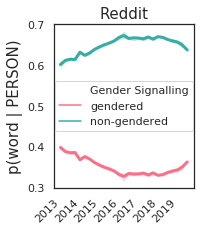

In [497]:
sns.set(style="white", font_scale=1)
# FINAL PLOT FOR REDDIT, DUDE CONTROLLED DT, ALL OVER TIME
sns.set_style("white")
timeaxisname = 'Time'
gendered_legendname = 'Gender Signalling'

# Messy Read-ins
print("Reading csvs...")
df = pd.read_csv("fastcounts-monthlycounts.txt",
                sep='\t', names=['filepath', 'word', 'count'])

# Gendered v. Non-Gendered
gendered = ['guy', 'man', 'bro', 'dude', 'girl', 'fella', 'dudes',
           'dudettes', 'bros', 'guys', 'girls']
non_gendered = ['fam', 'buddy', 'dawg', 'pal', 'homie', 'comrade', 'person', 'individual', 'mate',
               'dawgs', 'peeps', 'folks', 'persons', 'comrades', 'buddies', 'pals', 'mates', 'homies', 'people']

### DUDE ONLY ###
df = df[df['word'].isin(gendered + non_gendered)]
#################

df[gendered_legendname] = 'gendered'
df.loc[df['word'].isin(non_gendered), gendered_legendname] = 'non-gendered'
df['year'] = df['filepath'].str[3:7].astype(int)
df['month'] = df['filepath'].str[8:10].astype(int)
del df['filepath']

df_totals = df.groupby(['year', 'month'], as_index=False).agg({'count': 'sum'})
df['percentage'] = 0.0
for idx, row in tqdm(df.iterrows(), total=len(df)):
    total = df_totals.loc[(df_totals['year'] == row['year']) &
                         (df_totals['month'] == row['month']), 'count']
    df.at[idx, 'percentage'] = row['count'] / total

df = df.groupby(['year', 'month', gendered_legendname],as_index=False).agg({'percentage': 'sum'})

# Reformatting
print("Reformatting...")
df[timeaxisname] = ''
for index, row in tqdm(df.iterrows(), total=len(df)):
    if int(row['month']) in range(1,4):
         df.at[index, timeaxisname] = str(row['year']) + ' ' + '1-3 Mo'
    elif int(row['month']) in range(4,7):
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '4-6 Mo'
    elif int(row['month']) in range(7,10):
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '7-9 Mo'
    else:
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '9-12 Mo'
timeaxis_sorted = df[timeaxisname].sort_values().unique()

temp = []
for idx, x in enumerate(timeaxis_sorted):
    if '1-' in x: temp.append(x[0:4])
    else: temp.append('')
timeaxis_sorted = temp

# Plotting
plt.figure(figsize=(2.5,3))
fig = sns.lineplot(x=timeaxisname, y="percentage", hue=gendered_legendname, data=df,
                  hue_order=['gendered', 'non-gendered'], palette="husl", linewidth=3)
ax = plt.gca()
ax.set_xticklabels(labels=timeaxis_sorted, rotation=45, ha='right')

fig.set_xlabel('')
fig.set_ylabel('p(word | PERSON)', fontsize=15)
fig.axes.set_title("Reddit", fontsize=15)

fig.legend(loc='center right', bbox_to_anchor=(1.035, 0.5), ncol=1)
# legend = fig.get_legend()
# export_legend(legend, filename="plots-final/time-general/dude-legend.pdf")
# legend.remove()

plt.savefig('plots-final/time-general/dude-Reddit.pdf', bbox_inches='tight')    

In [120]:
# PARTNER CHECK FIRST

timeaxisname = 'time'

# Messy Read-ins
df = pd.read_csv("partner-check-first.txt", sep='\t',
                names=['percentage', 'word', 'trial', 'year', 'month', 'subreddit', 'category', 'num_valid'])

# Filter for SIGOTHER terms
df = df[df['word'].isin(['partner', 'spouse', 'girlfriend', 'boyfriend', 'husband', 'wife'])]


# # Formatting
df[timeaxisname] = ''
for index, row in tqdm(df.iterrows(), total=len(df)):
    if int(row['month']) in range(1,7):
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '1-6 Mo'
    else:
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '7-12 Mo'
timeaxis_sorted = df[timeaxisname].sort_values().unique()
# df['month'] = df.month.map("{:02}".format)
# df[timeaxisname] = df.year.map(str) + "-" + df.month
# df[timeaxisname] = pd.to_datetime(df[timeaxisname])
# timeaxis_sorted = df[timeaxisname].dt.strftime('%Y-%m').sort_values().unique()

temp = []
for idx, x in enumerate(timeaxis_sorted):
    if '1-' in x: temp.append(x[0:4])
    else: temp.append('')
timeaxis_sorted = temp

# Cleanup Filtering
#df = df[['percentage', 'word', 'subreddit', 'category', 'trial', 'time']]

Plotting for Block sexuality
Heterosexual (0.9826055996083466, 3.852170276346499e-10)
Lgbt+ (0.15630505007930184, 0.593610002218422)
Plotting for Block gender
Men (0.447658209017275, 0.1084704010472807)
Transgender (-0.21996111527928966, 0.4498804996793299)
Women (0.8946335935157811, 1.5688047293753294e-05)
Plotting for Block religion
Christianity (-0.1611059383110389, 0.5821702382138964)
General (-0.3843651572750379, 0.17481315605811312)
Islam (0.6737074139492417, 0.008250717515680657)
Judaism (0.3200004230457276, 0.26469948169723695)
Nonbelievers (0.6348050554690333, 0.014731612776013231)
Other (0.09528124200789839, 0.7459311500324514)
Plotting for Block politics
Conservative (-0.3432875614043237, 0.22949580007769022)
Liberal (-0.4437335756157761, 0.11198132161785955)
Plotting for Block age
Old (0.11660385034716406, 0.6913870320809434)
Young (0.6550682940114191, 0.010998473579533765)


<Figure size 432x288 with 0 Axes>

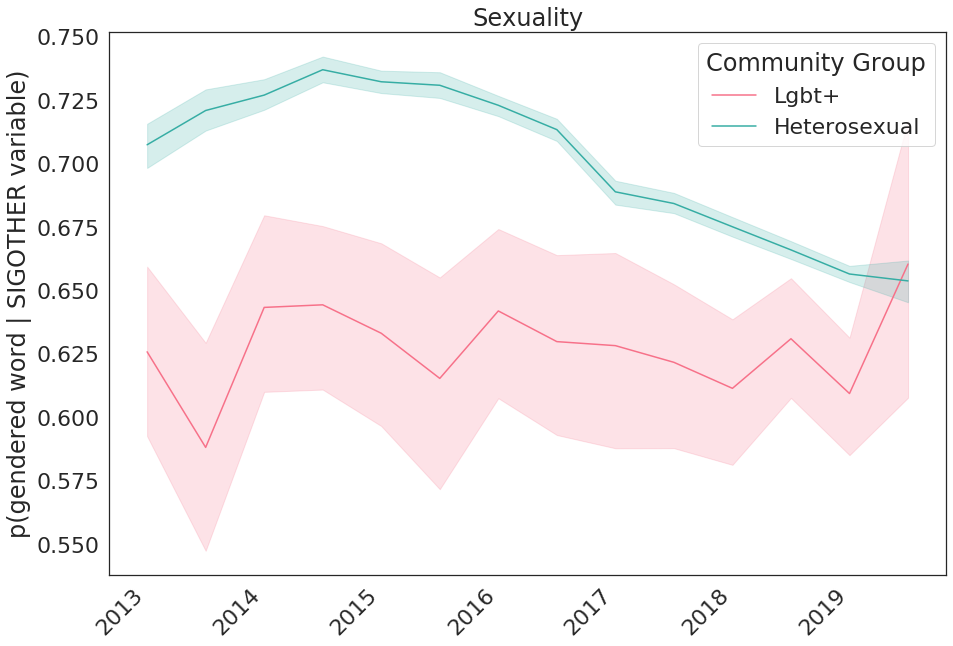

<Figure size 432x288 with 0 Axes>

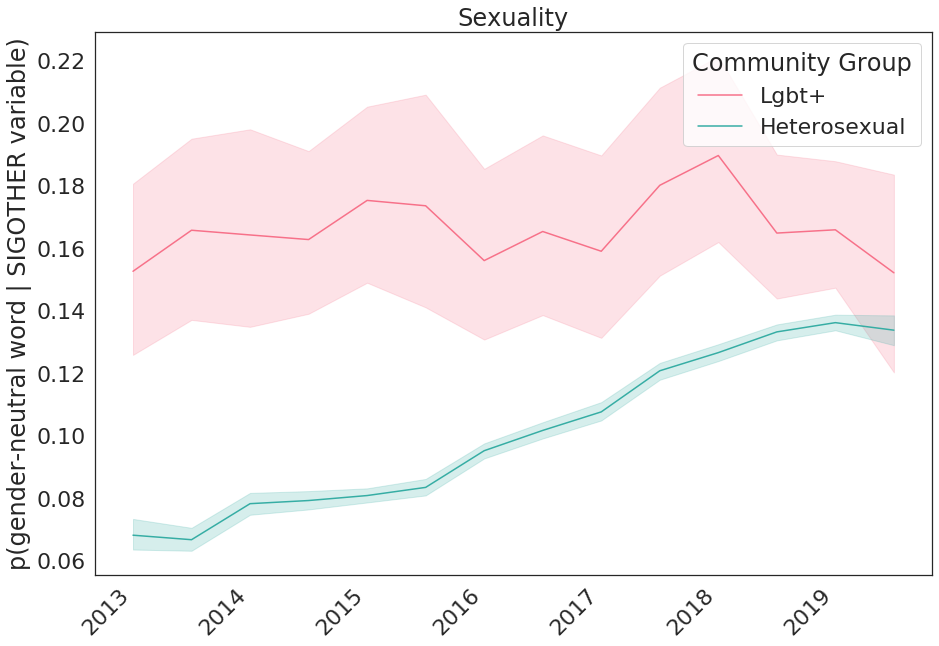

<Figure size 432x288 with 0 Axes>

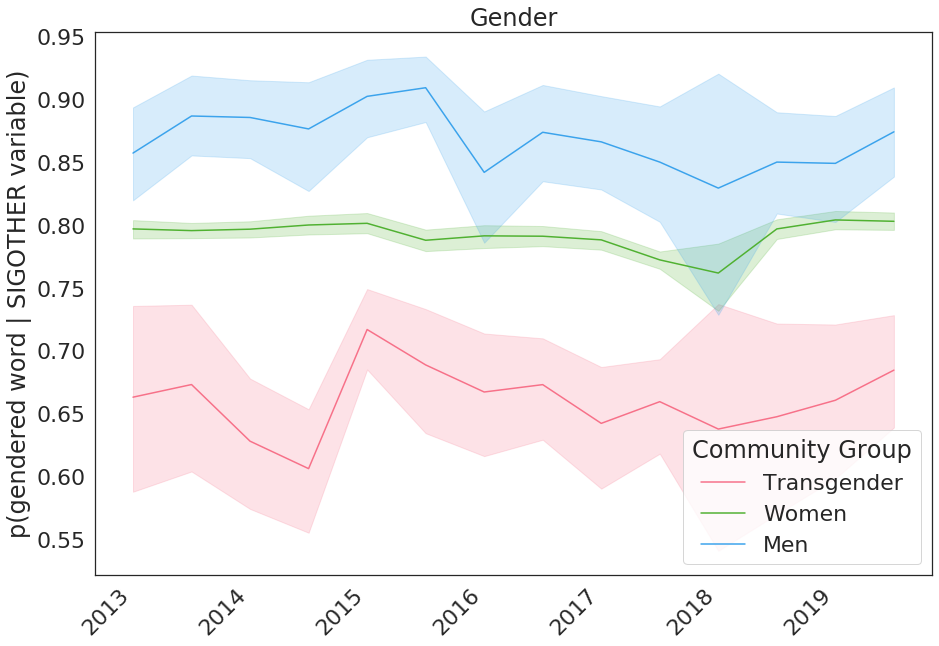

<Figure size 432x288 with 0 Axes>

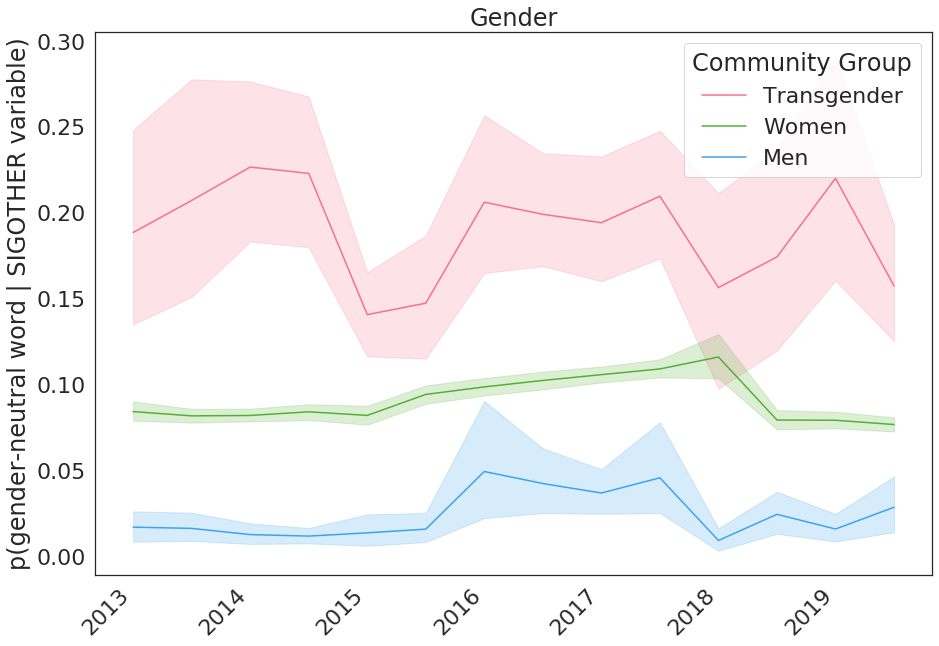

<Figure size 432x288 with 0 Axes>

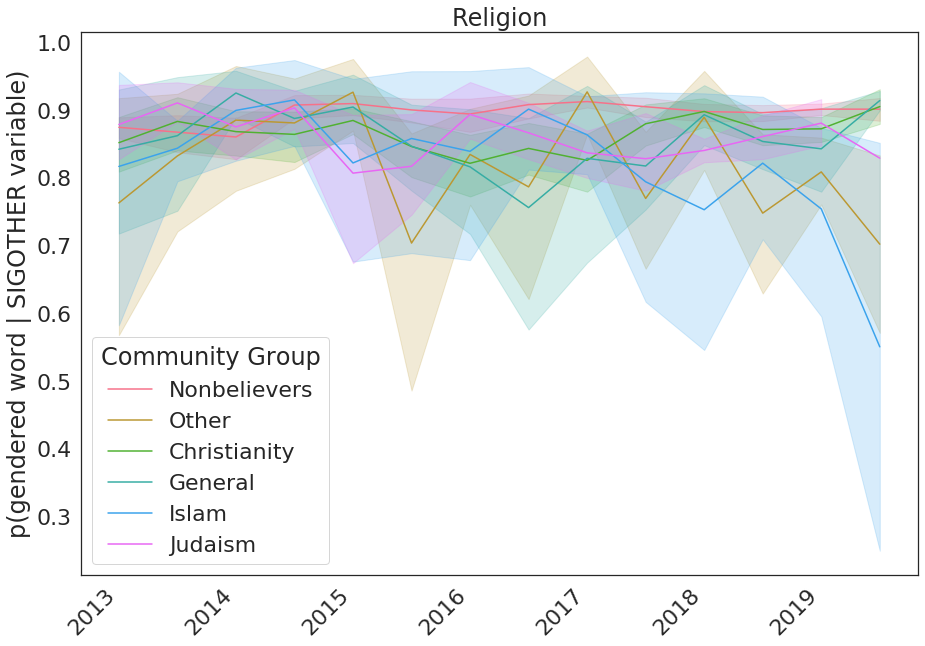

<Figure size 432x288 with 0 Axes>

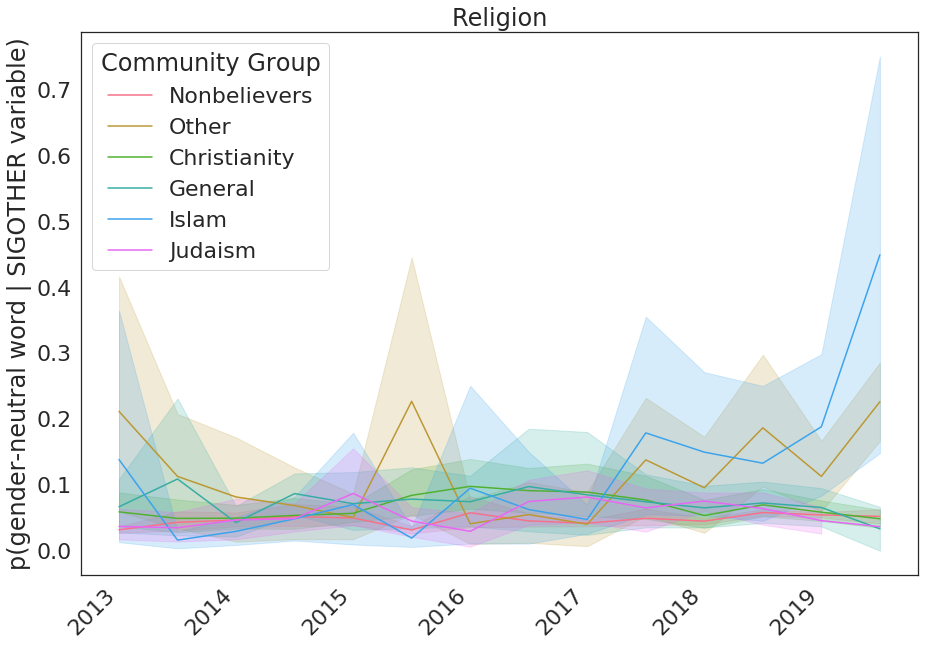

<Figure size 432x288 with 0 Axes>

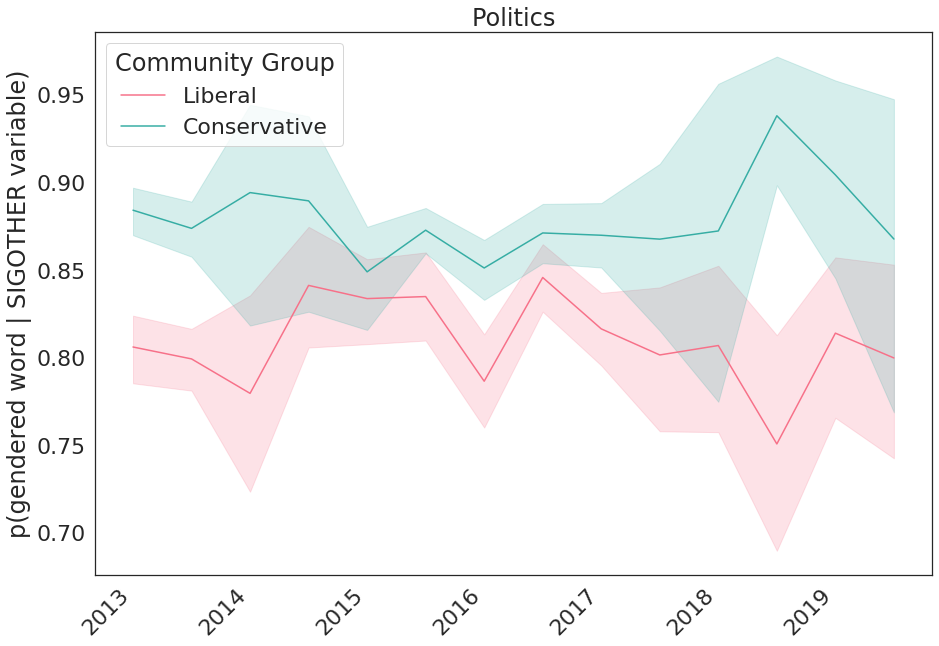

<Figure size 432x288 with 0 Axes>

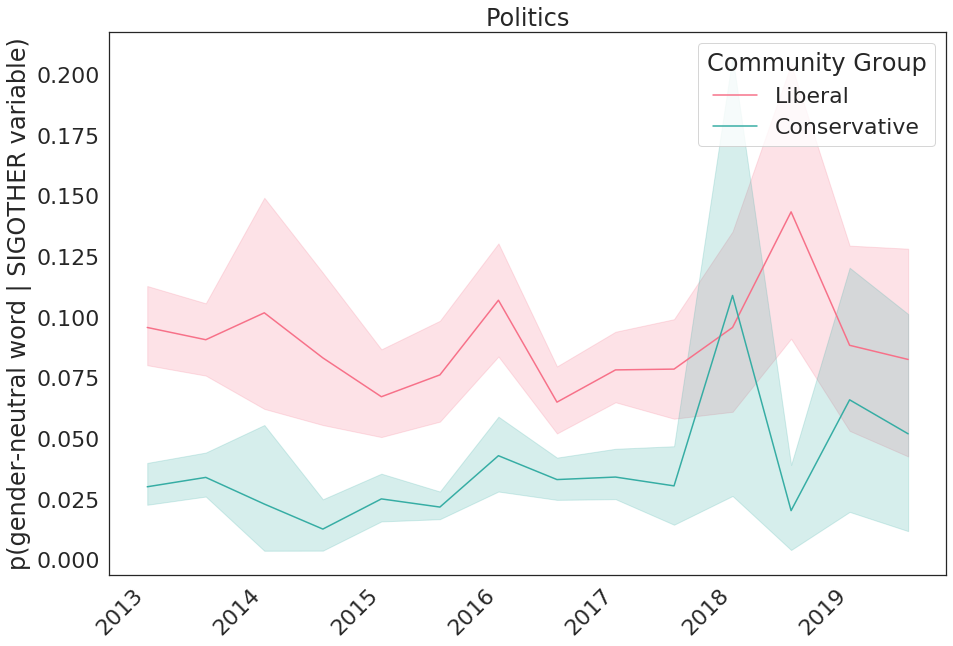

<Figure size 432x288 with 0 Axes>

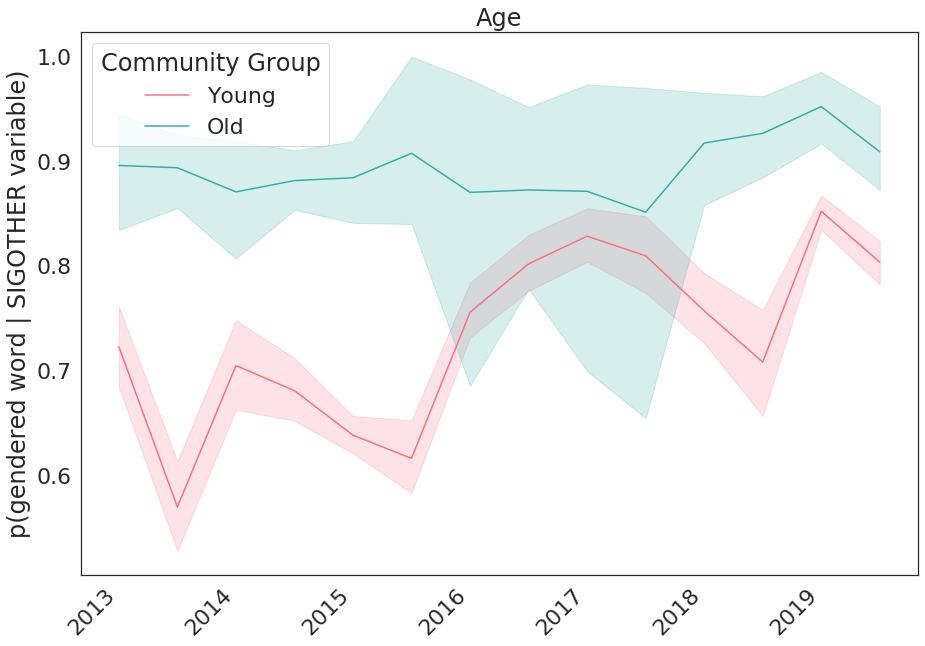

<Figure size 432x288 with 0 Axes>

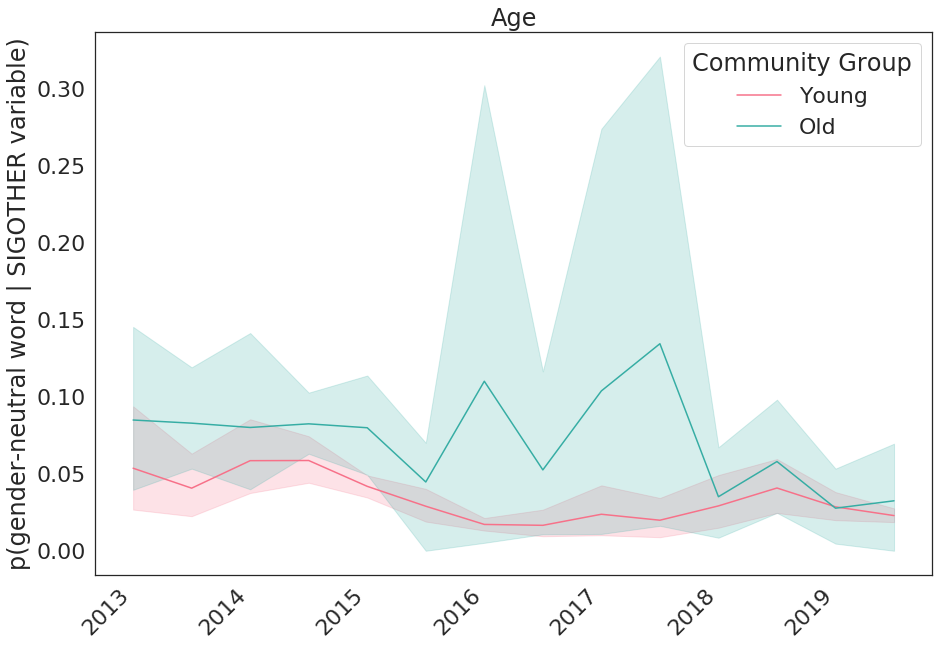

In [121]:
# PARTNER CHECK FIRST
sns.set_style("white")

### SUNDAY CHANGES ###
df.loc[df['category'] == 'politics_left', 'category'] = 'politics_liberal' 
df.loc[df['category'] == 'politics_right', 'category'] = 'politics_conservative' 
df.loc[df['category'] == 'sexuality_heteronormative', 'category'] = 'sexuality_heterosexual' 
######################

### Inclusivity Changes ###
df = df[df['category'] != 'politics_libertarian']
df = df[df['category'] != 'gender_Gender Critical']
df = df[df['category'] != 'sexuality_asexual']
df.loc[df['category'] == 'sexuality_lgbtq', 'category'] = 'sexuality_LGBT+' 
##########################

# Plotting Goodness
for block in ['sexuality', 'gender', 'religion', 'politics', 'age']:
    print("Plotting for Block", block)
    block_df = df[df['category'].str.contains(block)]
    
    # Sexuality
    block_df = block_df[block_df['category'] != 'sexuality_asexual']
    # Gender
    block_df.loc[block_df['category'] == 'gender_other', 'category'] = 'gender_Gender Critical'
    block_df = block_df[block_df['category'] != 'gender_Gender Critical']
    # Politics
    block_df = block_df[block_df['category'] != 'politics_general']
    # Religion
    block_df = block_df[block_df['category'] != 'religion_eastern']
    # block_df = block_df[block_df['word'] != 'spouse']
    
    for cat in block_df['category'].unique():
        block_df.loc[block_df['category'] == cat, 'category'] = (cat[len(block)+1:]).capitalize()
    block_df.rename(columns = {'category':'Community Group'}, inplace = True)
    
    ### Heteronormative Terms VS Gender-Neutral ###
    
    plt.figure()
    block_df_1 = block_df[block_df['word'].isin(['girlfriend', 'boyfriend', 'husband', 'wife'])]
    block_df_1 = block_df_1.groupby(['subreddit', 'Community Group', 'trial', 'time', 'month', 'year'], as_index=False).agg({'percentage': 'sum'})
    fig, ax = plt.subplots(figsize=(15,10))
    fig = sns.lineplot(ax=ax, x=timeaxisname, y="percentage", hue="Community Group", data=block_df_1,
                       palette="husl")
    fig.set(xlabel='', ylabel='p(gendered word | SIGOTHER variable)', title=block.capitalize())
    ax = plt.gca()
    ax.set_xticklabels(labels=timeaxis_sorted, rotation=45, ha='right')
    plt.savefig('plots-final/partner-prp-time/' + block + '-gendered-firstperson.pdf', bbox_inches='tight')
    
    plt.figure()
    block_df_2 = block_df[block_df['word'].isin(['partner', 'spouse'])]
    block_df_2 = block_df_2.groupby(['subreddit', 'Community Group', 'trial', 'time', 'month', 'year'], as_index=False).agg({'percentage': 'sum'})
    fig, ax = plt.subplots(figsize=(15,10))
    fig = sns.lineplot(ax=ax, x=timeaxisname, y="percentage", hue="Community Group", data=block_df_2,
                       palette="husl")
    fig.set(xlabel='', ylabel='p(gender-neutral word | SIGOTHER variable)', title=block.capitalize())
    ax = plt.gca()
    ax.set_xticklabels(labels=timeaxis_sorted, rotation=45, ha='right')
    plt.savefig('plots-final/partner-prp-time/' + block + '-genderneutral-firstperson.pdf', bbox_inches='tight')
    
    ### Correlations for Gender-Neutral ###
    
    block_df_2 = block_df_2.groupby(['Community Group', 'time'], as_index=False).agg({'percentage': 'mean'})
    for c_g in block_df_2['Community Group'].unique():
        values = block_df_2[block_df_2['Community Group'] == c_g].sort_values(by=['time'], ascending=True)['percentage'].tolist()
        pr = pearsonr(range(len(values)), values)
        print(c_g, pr)
        
    
#     # Plotting for specific words:
#     for word in block_df['word'].unique():
#         plt.figure()
#         block_df_word = block_df[block_df['word'] == word]
#         fig = sns.lineplot(x=timeaxisname, y="percentage", hue="Community Group", data=block_df_word,
#                       palette="husl")
#         fig.set(ylabel='p(' + word + ' | SIGOTHER variable)', title=block.capitalize())

#         ax = plt.gca()
#         ax.set_xticklabels(labels=timeaxis_sorted, rotation=45, ha='right')
#         plt.savefig('plots-final/partner-prp-time/' + block + '-' + word + '.pdf', bbox_inches='tight')

In [108]:
# PARTNER CHECK THIRD

timeaxisname = 'time'

# Messy Read-ins
df = pd.read_csv("partner-check-third.txt", sep='\t',
                names=['percentage', 'word', 'trial', 'year', 'month', 'subreddit', 'category', 'num_valid'])

# Filter for SIGOTHER terms
df = df[df['word'].isin(['partner', 'spouse', 'girlfriend', 'boyfriend', 'husband', 'wife'])]

# # Formatting
df[timeaxisname] = ''
for index, row in tqdm(df.iterrows(), total=len(df)):
    if int(row['month']) in range(1,7):
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '1-6 Mo'
    else:
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '7-12 Mo'
timeaxis_sorted = df[timeaxisname].sort_values().unique()
# df['month'] = df.month.map("{:02}".format)
# df[timeaxisname] = df.year.map(str) + "-" + df.month
# df[timeaxisname] = pd.to_datetime(df[timeaxisname])
# timeaxis_sorted = df[timeaxisname].dt.strftime('%Y-%m').sort_values().unique()

temp = []
for idx, x in enumerate(timeaxis_sorted):
    if '1-' in x: temp.append(x[0:4])
    else: temp.append('')
timeaxis_sorted = temp

# Cleanup Filtering
#df = df[['percentage', 'word', 'subreddit', 'category', 'trial', 'time']]

Plotting for Block sexuality
Heterosexual (0.9166376514249656, 4.040520852141674e-06)
Lgbt+ (0.12615374570203805, 0.6673850429982721)
Plotting for Block gender
Men (0.24840134507869271, 0.39182169121295907)
Transgender (0.26599340277840583, 0.3580020961463805)
Women (0.8137602176541634, 0.00039809710638583225)
Plotting for Block religion
Christianity (0.37713924892649053, 0.18375219299027604)
General (-0.2828234954730666, 0.32720110069534897)
Islam (0.8081657563350604, 0.0004693448797800004)
Judaism (-0.05773502836217619, 0.8445742898828215)
Nonbelievers (0.34865335079383186, 0.22181702615599866)
Other (-0.257759833738775, 0.37362656520544174)
Plotting for Block politics
Conservative (-0.4490475029660159, 0.10724587894952856)
Liberal (-0.7659712803205447, 0.001401997094534936)
Plotting for Block age
Old (0.1117167844517716, 0.7037764709148646)
Young (0.39749653416044245, 0.15930069959901763)


<Figure size 432x288 with 0 Axes>

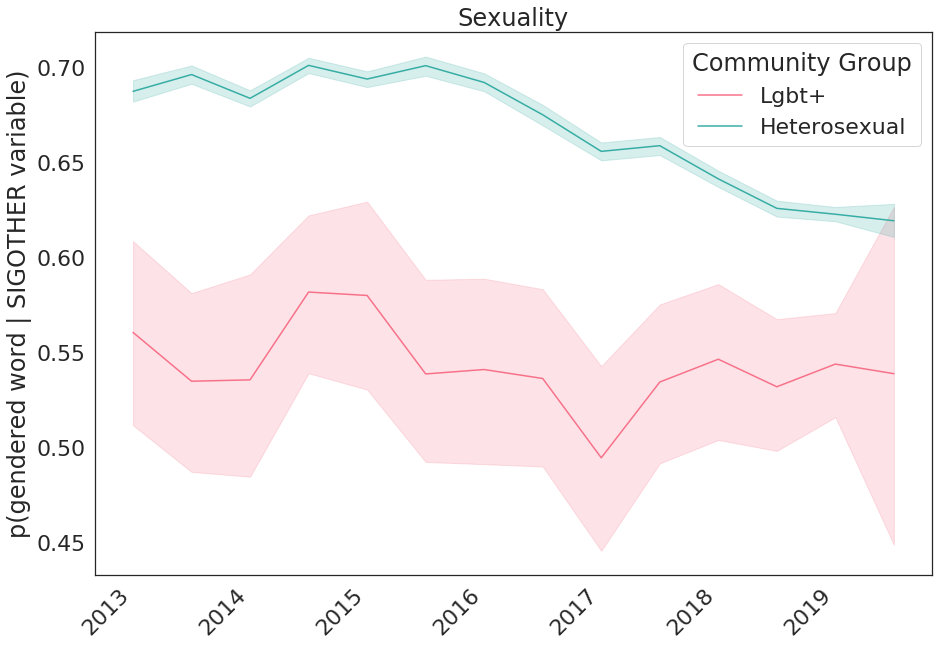

<Figure size 432x288 with 0 Axes>

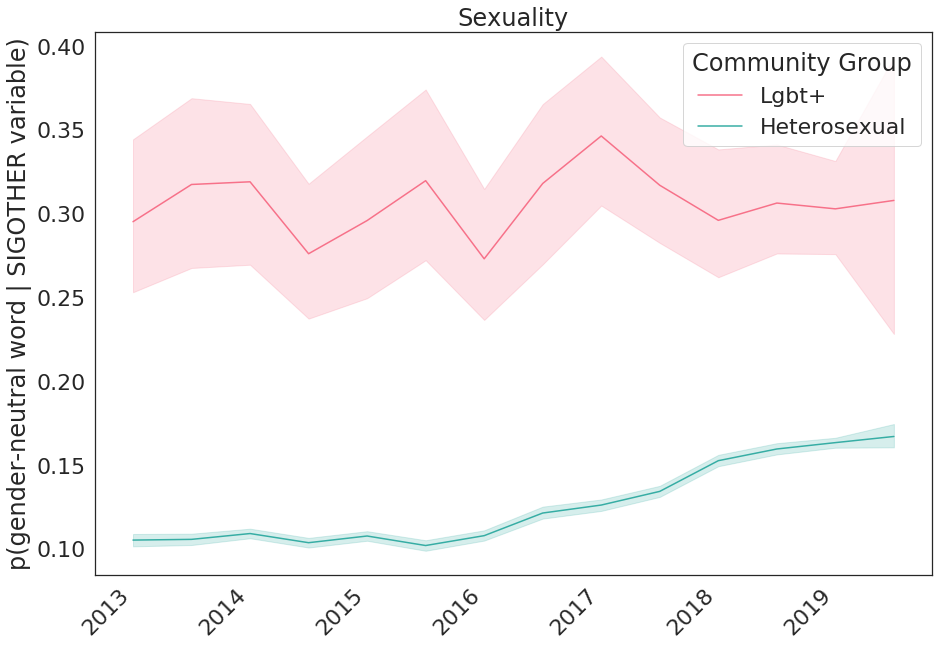

<Figure size 432x288 with 0 Axes>

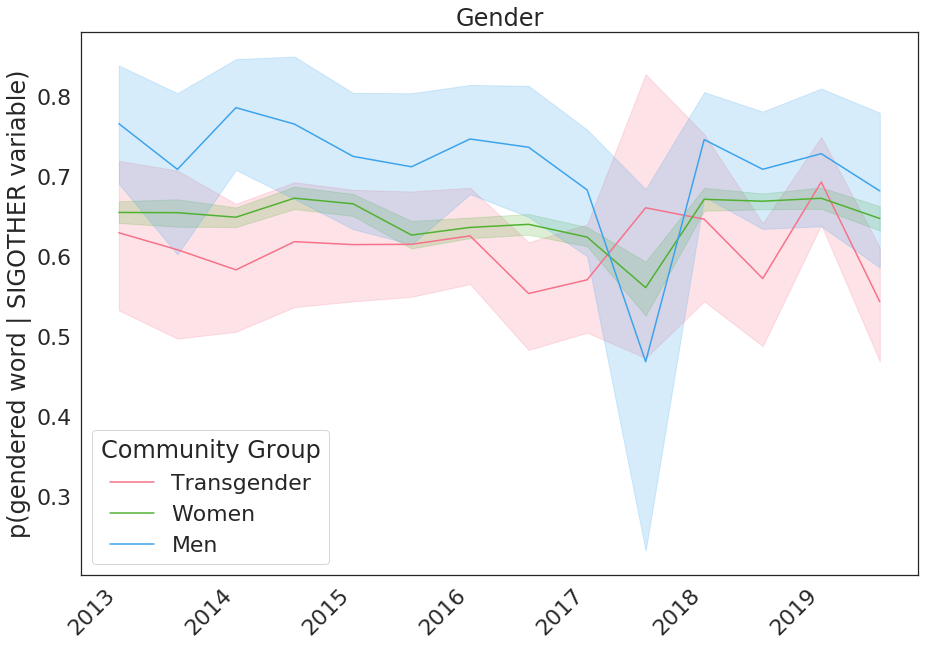

<Figure size 432x288 with 0 Axes>

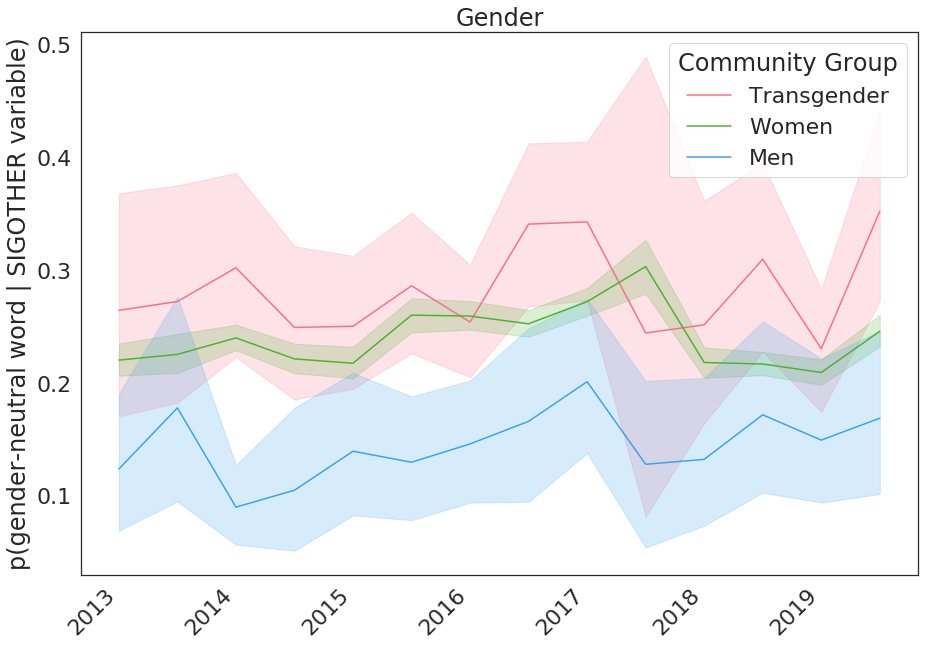

<Figure size 432x288 with 0 Axes>

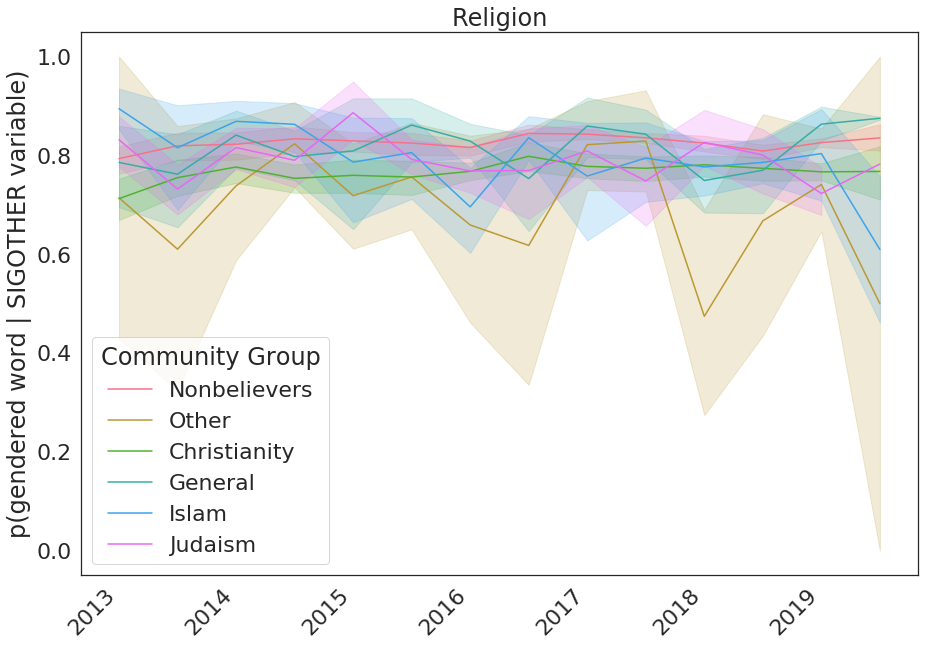

<Figure size 432x288 with 0 Axes>

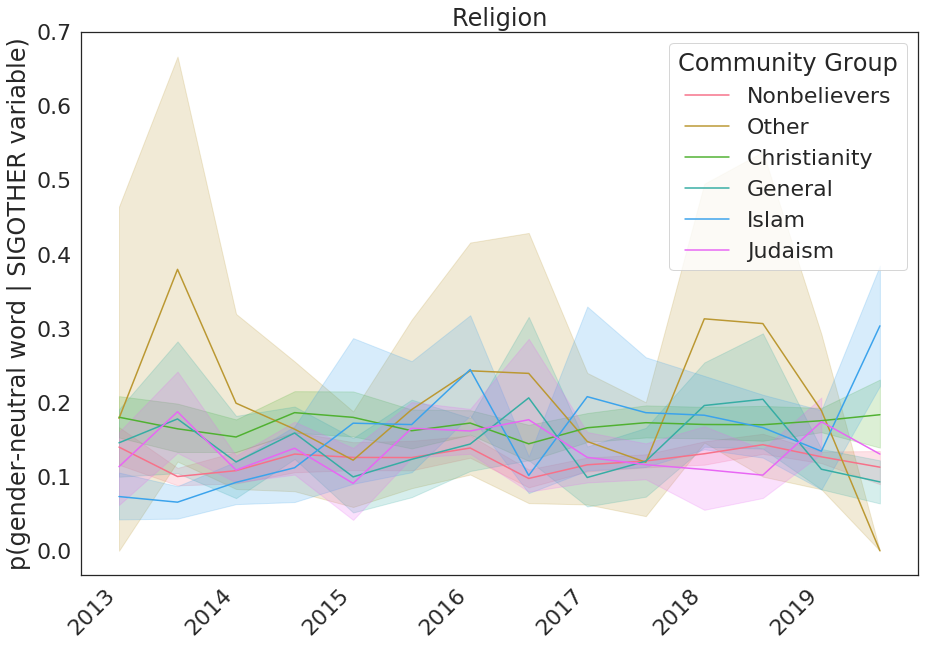

<Figure size 432x288 with 0 Axes>

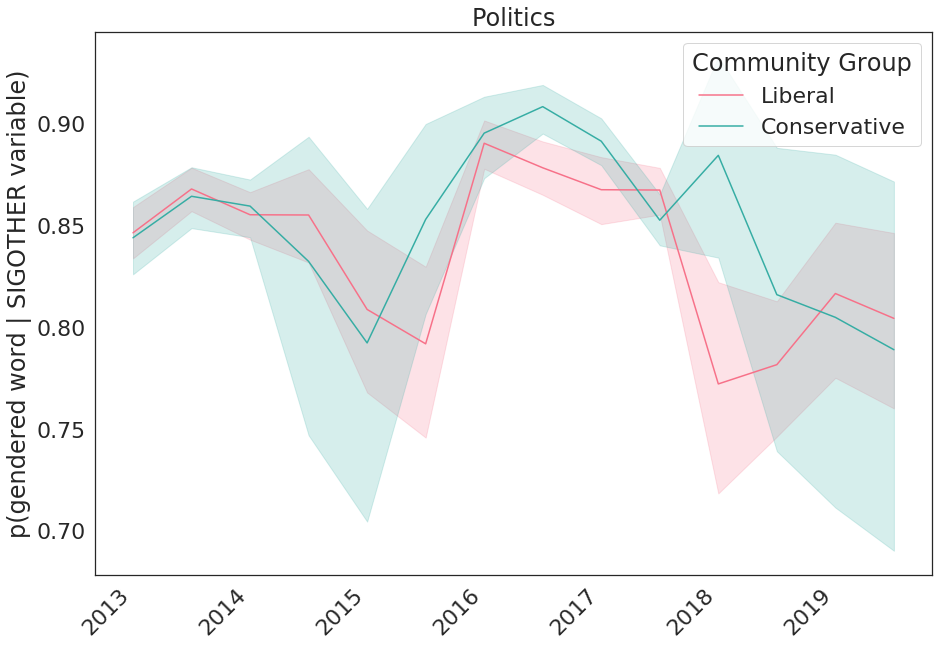

<Figure size 432x288 with 0 Axes>

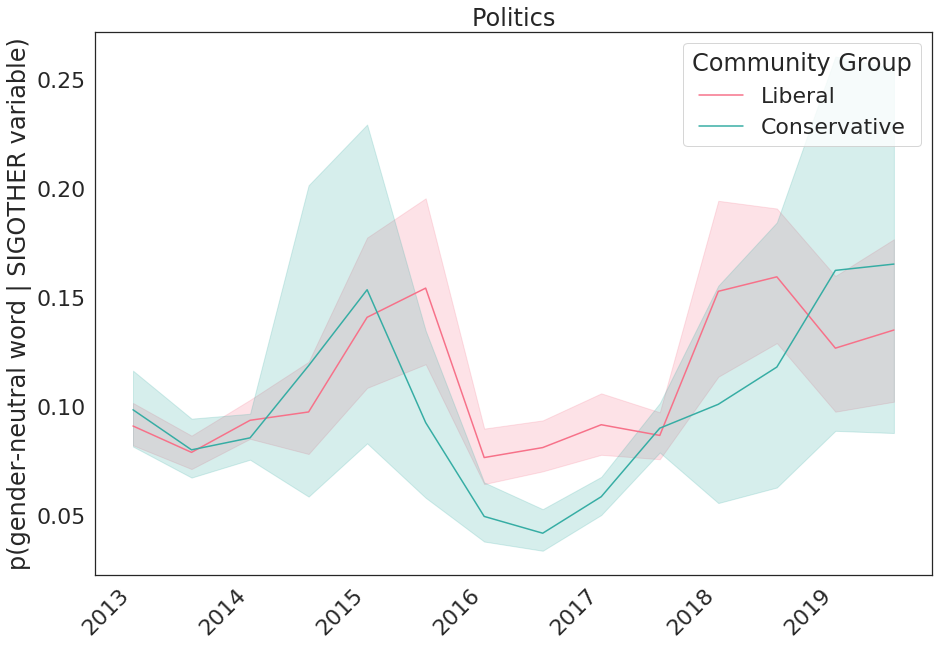

<Figure size 432x288 with 0 Axes>

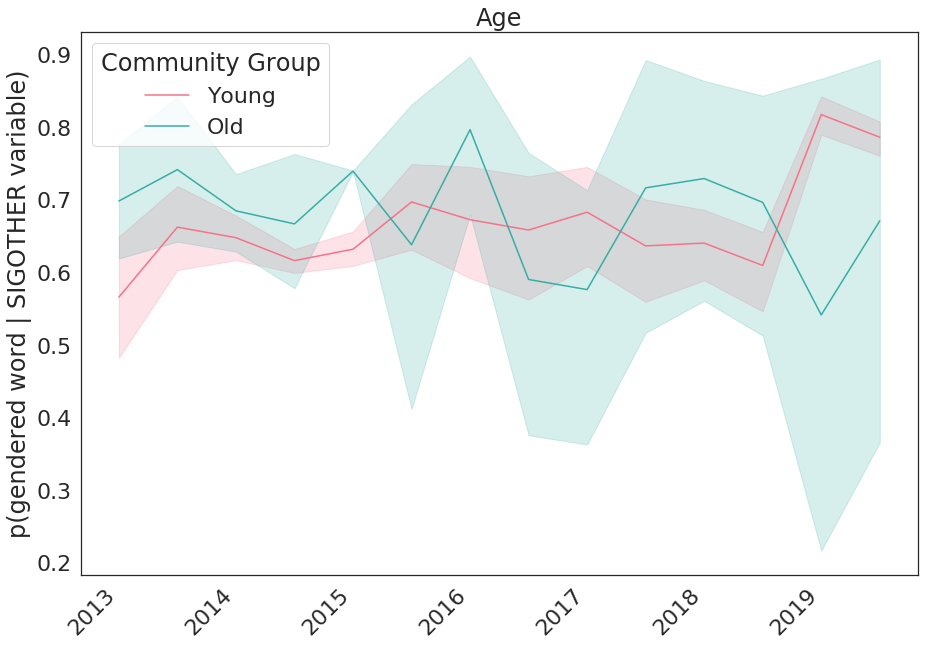

<Figure size 432x288 with 0 Axes>

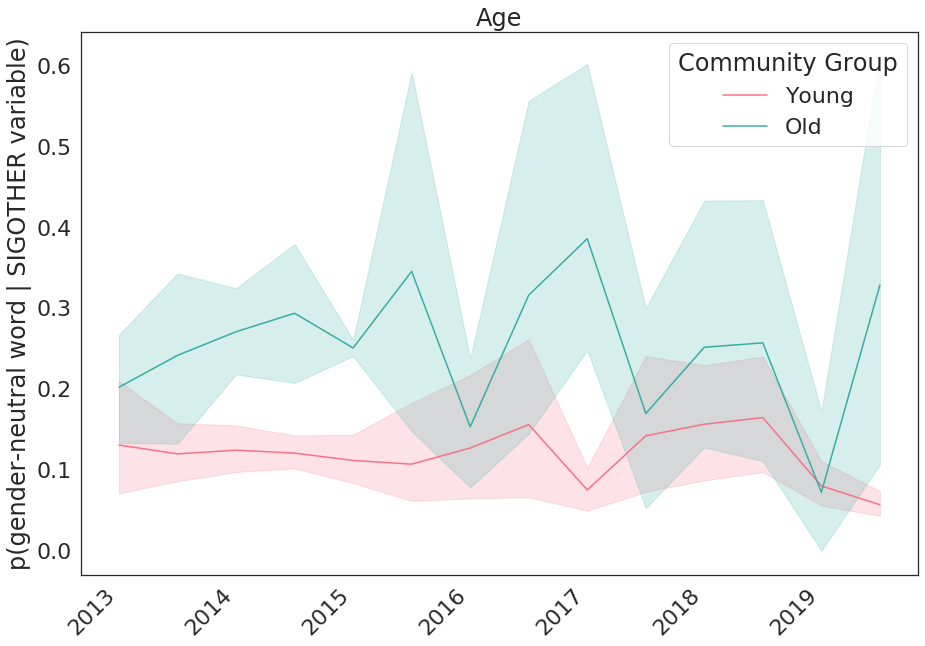

In [119]:
# PARTNER CHECK THIRD
sns.set_style("white")

### SUNDAY CHANGES ###
df.loc[df['category'] == 'politics_left', 'category'] = 'politics_liberal' 
df.loc[df['category'] == 'politics_right', 'category'] = 'politics_conservative' 
df.loc[df['category'] == 'sexuality_heteronormative', 'category'] = 'sexuality_heterosexual' 
######################

### Inclusivity Changes ###
df = df[df['category'] != 'politics_libertarian']
df = df[df['category'] != 'gender_Gender Critical']
df = df[df['category'] != 'sexuality_asexual']
df.loc[df['category'] == 'sexuality_lgbtq', 'category'] = 'sexuality_LGBT+' 
##########################

# Plotting Goodness
for block in ['sexuality', 'gender', 'religion', 'politics', 'age']:
    print("Plotting for Block", block)
    block_df = df[df['category'].str.contains(block)]
    
    # Sexuality
    block_df = block_df[block_df['category'] != 'sexuality_asexual']
    # Gender
    block_df.loc[block_df['category'] == 'gender_other', 'category'] = 'gender_Gender Critical'
    block_df = block_df[block_df['category'] != 'gender_Gender Critical']
    # Politics
    block_df = block_df[block_df['category'] != 'politics_general']
    # Religion
    block_df = block_df[block_df['category'] != 'religion_eastern']
    # block_df = block_df[block_df['word'] != 'spouse']
    
    for cat in block_df['category'].unique():
        block_df.loc[block_df['category'] == cat, 'category'] = (cat[len(block)+1:]).capitalize()
    block_df.rename(columns = {'category':'Community Group'}, inplace = True)
    
    ### Heteronormative Terms VS Gender-Neutral ###
    
    plt.figure()
    block_df_1 = block_df[block_df['word'].isin(['girlfriend', 'boyfriend', 'husband', 'wife'])]
    block_df_1 = block_df_1.groupby(['subreddit', 'Community Group', 'trial', 'time', 'month', 'year'], as_index=False).agg({'percentage': 'sum'})
    fig, ax = plt.subplots(figsize=(15,10))
    fig = sns.lineplot(ax=ax, x=timeaxisname, y="percentage", hue="Community Group", data=block_df_1,
                       palette="husl")
    fig.set(xlabel='', ylabel='p(gendered word | SIGOTHER variable)', title=block.capitalize())
    ax = plt.gca()
    ax.set_xticklabels(labels=timeaxis_sorted, rotation=45, ha='right')
    plt.savefig('plots-final/partner-prp-time/' + block + '-gendered-thirdperson.pdf', bbox_inches='tight')
    
    plt.figure()
    block_df_2 = block_df[block_df['word'].isin(['partner', 'spouse'])]
    block_df_2 = block_df_2.groupby(['subreddit', 'Community Group', 'trial', 'time', 'month', 'year'], as_index=False).agg({'percentage': 'sum'})
    fig, ax = plt.subplots(figsize=(15,10))
    fig = sns.lineplot(ax=ax, x=timeaxisname, y="percentage", hue="Community Group", data=block_df_2,
                       palette="husl",)
    fig.set(xlabel='', ylabel='p(gender-neutral word | SIGOTHER variable)', title=block.capitalize())
    ax = plt.gca()
    ax.set_xticklabels(labels=timeaxis_sorted, rotation=45, ha='right')
    plt.savefig('plots-final/partner-prp-time/' + block + '-genderneutral-thirdperson.pdf', bbox_inches='tight')
    
    ### Correlations for Gender-Neutral ###
    
    block_df_2 = block_df_2.groupby(['Community Group', 'time'], as_index=False).agg({'percentage': 'mean'})
    for c_g in block_df_2['Community Group'].unique():
        values = block_df_2[block_df_2['Community Group'] == c_g].sort_values(by=['time'], ascending=True)['percentage'].tolist()
        pr = pearsonr(range(len(values)), values)
        print(c_g, pr)
        
    
#     # Plotting for specific words:
#     for word in block_df['word'].unique():
#         plt.figure()
#         block_df_word = block_df[block_df['word'] == word]
#         fig = sns.lineplot(x=timeaxisname, y="percentage", hue="Community Group", data=block_df_word,
#                       palette="husl")
#         fig.set(ylabel='p(' + word + ' | SIGOTHER variable)', title=block.capitalize())

#         ax = plt.gca()
#         ax.set_xticklabels(labels=timeaxis_sorted, rotation=45, ha='right')
#         plt.savefig('plots-final/partner-prp-time/' + block + '-' + word + '.pdf', bbox_inches='tight')

Reading csvs...
Reformatting...


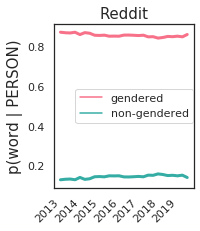

In [48]:
# FINAL PLOT FOR REDDIT, DUDE CONTROLLED DT, ALL OVER TIME
sns.set_style("white")
timeaxisname = 'Time'
gendered_legendname = 'Gender Signalling'

# Messy Read-ins
print("Reading csvs...")
df = pd.read_csv("repercent3.txt",
                sep='\t', names=['percentage', 'word', 'trial', 'year', 'month', 'category', 'num_valid'])
df = df[df['category'] == 'general']

# Gendered v. Non-Gendered
gendered = ['guy', 'man', 'bro', 'dude', 'girl', 'fella', 'dudes',
           'dudettes', 'bros', 'guys', 'girls']
non_gendered = ['fam', 'buddy', 'dawg', 'pal', 'homie', 'comrade', 'person', 'individual', 'mate',
               'dawgs', 'peeps', 'folks', 'persons', 'comrades', 'buddies', 'pals', 'mates', 'homies']

df[gendered_legendname] = 'gendered'
df.loc[df['word'].isin(non_gendered), gendered_legendname] = 'non-gendered'
df = df.groupby(['trial', 'year', 'month', 'category', gendered_legendname],as_index=False).agg({'percentage': 'sum'})

# Reformatting
print("Reformatting...")
df[timeaxisname] = ''
for index, row in tqdm(df.iterrows(), total=len(df)):
    if int(row['month']) in range(1,4):
         df.at[index, timeaxisname] = str(row['year']) + ' ' + '1-3 Mo'
    elif int(row['month']) in range(4,7):
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '4-6 Mo'
    elif int(row['month']) in range(7,10):
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '7-9 Mo'
    else:
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '9-12 Mo'
timeaxis_sorted = df[timeaxisname].sort_values().unique()

temp = []
for idx, x in enumerate(timeaxis_sorted):
    if '1-' in x: temp.append(x[0:4])
    else: temp.append('')
timeaxis_sorted = temp

# Plotting
plt.figure(figsize=(2.5,3))
fig = sns.lineplot(x=timeaxisname, y="percentage", hue=gendered_legendname, data=df,
                  hue_order=['gendered', 'non-gendered'], palette="husl", linewidth=3)
ax = plt.gca()
ax.set_xticklabels(labels=timeaxis_sorted, rotation=45, ha='right')

fig.set_xlabel('')
fig.set_ylabel('p(word | PERSON)', fontsize=15)
fig.axes.set_title("Reddit", fontsize=15)

fig.legend(loc='center right', bbox_to_anchor=(1.035, 0.5), ncol=1)
# legend = fig.get_legend()
# export_legend(legend, filename="plots-final/time-general/dude-legend.pdf")
# legend.remove()

plt.savefig('plots-final/time-general/dude-Reddit.pdf', bbox_inches='tight')    

In [49]:
block_df_2 = df.groupby([gendered_legendname, timeaxisname], as_index=False).agg({'percentage': 'mean'})

values = block_df_2[block_df_2[gendered_legendname] == 'gendered'].sort_values(by=[timeaxisname], ascending=True)['percentage'].tolist()
pr = pearsonr(range(len(values)), values)
print(pr)

values = block_df_2[block_df_2[gendered_legendname] == 'non-gendered'].sort_values(by=[timeaxisname], ascending=True)['percentage'].tolist()
pr = pearsonr(range(len(values)), values)
print(pr)

(-0.7713954392656354, 2.474478227875568e-06)
(0.7713954392656033, 2.4744782278794384e-06)


In [ ]:
# FINAL PLOT FOR REDDIT, DUDE CONTROLLED DT, ALL OVER TIME
sns.set_style("white")
timeaxisname = 'Time'
gendered_legendname = 'Gender Signalling'

# Messy Read-ins
print("Reading csvs...")
df = pd.read_csv("repercent3.txt",
                sep='\t', names=['percentage', 'word', 'trial', 'year', 'month', 'category', 'num_valid'])
df = df[df['category'] == 'general']

# Gendered v. Non-Gendered
gendered = ['guy', 'man', 'bro', 'dude', 'girl', 'fella', 'dudes',
           'dudettes', 'bros', 'guys', 'girls']
non_gendered = ['fam', 'buddy', 'dawg', 'pal', 'homie', 'comrade', 'person', 'individual', 'mate',
               'dawgs', 'peeps', 'folks', 'persons', 'comrades', 'buddies', 'pals', 'mates', 'homies']

df[gendered_legendname] = 'gendered'
df.loc[df['word'].isin(non_gendered), gendered_legendname] = 'non-gendered'
df = df.groupby(['trial', 'year', 'month', 'category', gendered_legendname],as_index=False).agg({'percentage': 'sum'})

# Reformatting
print("Reformatting...")
df[timeaxisname] = ''
for index, row in tqdm(df.iterrows(), total=len(df)):
    if int(row['month']) in range(1,4):
         df.at[index, timeaxisname] = str(row['year']) + ' ' + '1-3 Mo'
    elif int(row['month']) in range(4,7):
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '4-6 Mo'
    elif int(row['month']) in range(7,10):
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '7-9 Mo'
    else:
        df.at[index, timeaxisname] = str(row['year']) + ' ' + '9-12 Mo'
timeaxis_sorted = df[timeaxisname].sort_values().unique()

temp = []
for idx, x in enumerate(timeaxis_sorted):
    if '1-' in x: temp.append(x[0:4])
    else: temp.append('')
timeaxis_sorted = temp

# Plotting
plt.figure(figsize=(2.5,3))
fig = sns.lineplot(x=timeaxisname, y="percentage", hue=gendered_legendname, data=df,
                  hue_order=['gendered', 'non-gendered'], palette="husl", linewidth=3)
ax = plt.gca()
ax.set_xticklabels(labels=timeaxis_sorted, rotation=45, ha='right')

fig.set_xlabel('')
fig.set_ylabel('p(word | PERSON)', fontsize=15)
fig.axes.set_title("Reddit", fontsize=15)

fig.legend(loc='center right', bbox_to_anchor=(1.035, 0.5), ncol=1)
# legend = fig.get_legend()
# export_legend(legend, filename="plots-final/time-general/dude-legend.pdf")
# legend.remove()

plt.savefig('plots-final/time-general/dude-Reddit.pdf', bbox_inches='tight')    